In [728]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from cmdstanpy import CmdStanModel
import pandas as pd
import json
import pickle
import os
from sklearn.mixture import GaussianMixture

from scipy import stats
from scipy import special

# Load data

## Behavioural data


In [729]:

df_raw = pd.read_csv('data/pilot/raw/20_01_2025/tom_dictator_v2_2025-01-20.csv')
                     
# Replace full stop with underscore in df_raw column names
df_raw.columns = df_raw.columns.str.replace('.', '_')

sessions = [
    'tgvqauld',
    'ta176utg'
]

# Only keep rows where session_id is in sessions and where participant_label is not NaN
df_full = df_raw[df_raw['session_code'].isin(sessions) & df_raw['participant_label'].notna() & (df_raw['participant__current_page_name'] == 'End')]
# Insert 
columns = ['participant_code', 'participant_label', 'session_code',
       
       'player_block_type', 'player_block_idx', 'player_idx_in_block', 'player_trust_cond', 'player_trust_label',
       'player_intention', 'player_interest', 
       'player_certainty', 'player_certainty_val', 'player_rigidity', 'player_rigidity_val',
       'player_k_lvl', 'player_trust_predicted', 'player_alpha_prior',
       'player_alpha_prior_entropy', 'player_alpha', 'player_alpha_entropy',
       'player_beta_prior', 'player_beta_prior_entropy', 'player_beta',
       'player_beta_entropy', 'player_beta_social_prior',
       'player_beta_social_prior_entropy', 'player_beta_social',
       'player_beta_social_entropy', 'player_path_taken',
       'player_perceived_certainty_certain',
       'player_perceived_certainty_uncertain',
       'player_perceived_certainty_immutable', 'player_attention',
       'player_attention_passed', 'player_attention_correct',

       'player_focus_work_high', 'player_focus_work_medium', 'player_focus_work_low',
       'player_strategy_high', 'player_strategy_low', 'player_strategy_medium',

       'subsession_round_number',
       'participant__current_app_name',
       'participant__current_page_name', 
       'player_payoff',
]


df = df_full[columns]

# If player is in column name, remove player_ from column name
df.columns = df.columns.str.replace('player_', '')


df_long = df[(df.block_type == 'test')][['participant_code', 'intention', 'certainty', 'rigidity', 'intention', 'trust_cond', 'path_taken']]

df_long['absent'] = df_long.trust_cond.map(lambda x: x == 'none')

# Get dummies for path taken and concat with df_long
path_taken_dummies = pd.get_dummies(df_long['path_taken'], prefix='', prefix_sep='')
df_long = pd.concat([df_long, path_taken_dummies], axis=1)

df_long['delivered'] = df_long['A'] + df_long['B'] > 0
df_long['path_hidden'] = df_long['B'] + df_long['C'] > 0

# Create path_idx column
path_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
}
df['path_idx'] = df['path_taken'].map(lambda x: path_dict[x])
df_long['path_length'] = df_long['path_taken'].map(lambda x: path_dict[x])

# Create certainty_lvl column
certainties_dict = {
    'uncertain': 1,
    'certain': 2,
    'immutable': 3,
}
df_long['certainty_lvl'] = df_long['certainty'].map(lambda x: certainties_dict[x])
df['certainty_lvl'] = df['certainty'].map(lambda x: certainties_dict[x])

# Create trust_lvl column
trust_dict = {
    'none': 4,
    'low': 1,
    'medium': 2,
    'high': 3,
}
df_long['trust_lvl'] = df_long['trust_cond'].map(lambda x: trust_dict[x])
df['trust_lvl'] = df['trust_cond'].map(lambda x: trust_dict[x])

# Assign unique integer to each participant and make sure it is the same for both df and df_long and recoverable
df_long['part_idx'] = pd.Categorical(df_long['participant_code']).codes
df['part_idx'] = pd.Categorical(df['participant_code']).codes



paths_colors = {
    'A': np.array([238, 154, 86])/255,
    'B': np.array([183, 117, 63])/255,
    'C': np.array([50, 114, 169])/255,
    'D': np.array([88, 182, 225])/255,
}

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/1846483637.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['path_idx'] = df['path_taken'].map(lambda x: path_dict[x])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/1846483637.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['certainty_lvl'] = df['certainty'].map(lambda x: certainties_dict[x])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/1846483637.py:84: SettingWithCopyWarning: 
A value is 

In [730]:
df_demo_raw = pd.read_csv("data/pilot/raw/20_01_2025/generic_demographics_2025-01-20.csv")

df_demo_raw.columns = df_demo_raw.columns.str.replace('.', '_')

sessions = [
    'tgvqauld',
    'ta176utg'
]

df_demo = df_demo_raw[df_demo_raw['session_code'].isin(sessions) & df_demo_raw.participant_label.notna()]
df_demo.columns = df_demo.columns.str.replace('player_', '')

df_demo['part_idx'] = pd.Categorical(df_demo['participant_code']).codes

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/713800357.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo['part_idx'] = pd.Categorical(df_demo['participant_code']).codes


## Model data

In [725]:
variants = [
    'nodelta',
    'full',
    #'onlyalpha',
    'nobeta'
    #'fullexp',
    #'nobetaexp',
    #'nodeltaexp'   
]

# Load data
variants_df_params_full = {}
variants_df_params = {}
variants_df_Ys = {}
variants_df_Ys_nobeta = {}
variants_fit = {}
for variant in variants:
    df_params_full = pd.read_csv(f'stan_files/tom_model_basic_{variant}_params.csv')
    variants_df_params[variant] = df_params_full

    df_params = df_params_full.groupby(['part_idx', 'participant_code', 'weight', 'param_code', 'param_name']).value.mean().reset_index()
    variants_df_params[variant] = df_params
    
    df_Ys = pd.read_csv(f'stan_files/tom_model_basic_{variant}_y_sim.csv')
    variants_df_Ys[variant] = df_Ys

    #df_Ys_nobeta = pd.read_csv(f'stan_files/tom_model_basic_{variant}_y_nobeta_sim.csv')
    #variants_df_Ys_nobeta[variant] = df_Ys_nobeta

    # Load Stan fit object
    with open(f'stan_files/tom_model_basic_{variant}_fit.pkl', 'rb') as f:
        fit = pickle.load(f)

    variants_fit[variant] = fit

## Run cluster analysis to rerun mixed effect models

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/1995236619.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = df['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/1995236619.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo['cluster'] = df_demo['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)


Cluster sizes: 
 cluster
0    49
1    50
Name: part_idx, dtype: int64
Cluster means: 
 [[ 0.36979028  0.28909025  4.3478767   4.17414668 11.05811244  4.91777298]
 [ 0.44277959  0.2473035   2.31071274  9.0560295  23.97873976 10.7544003 ]]


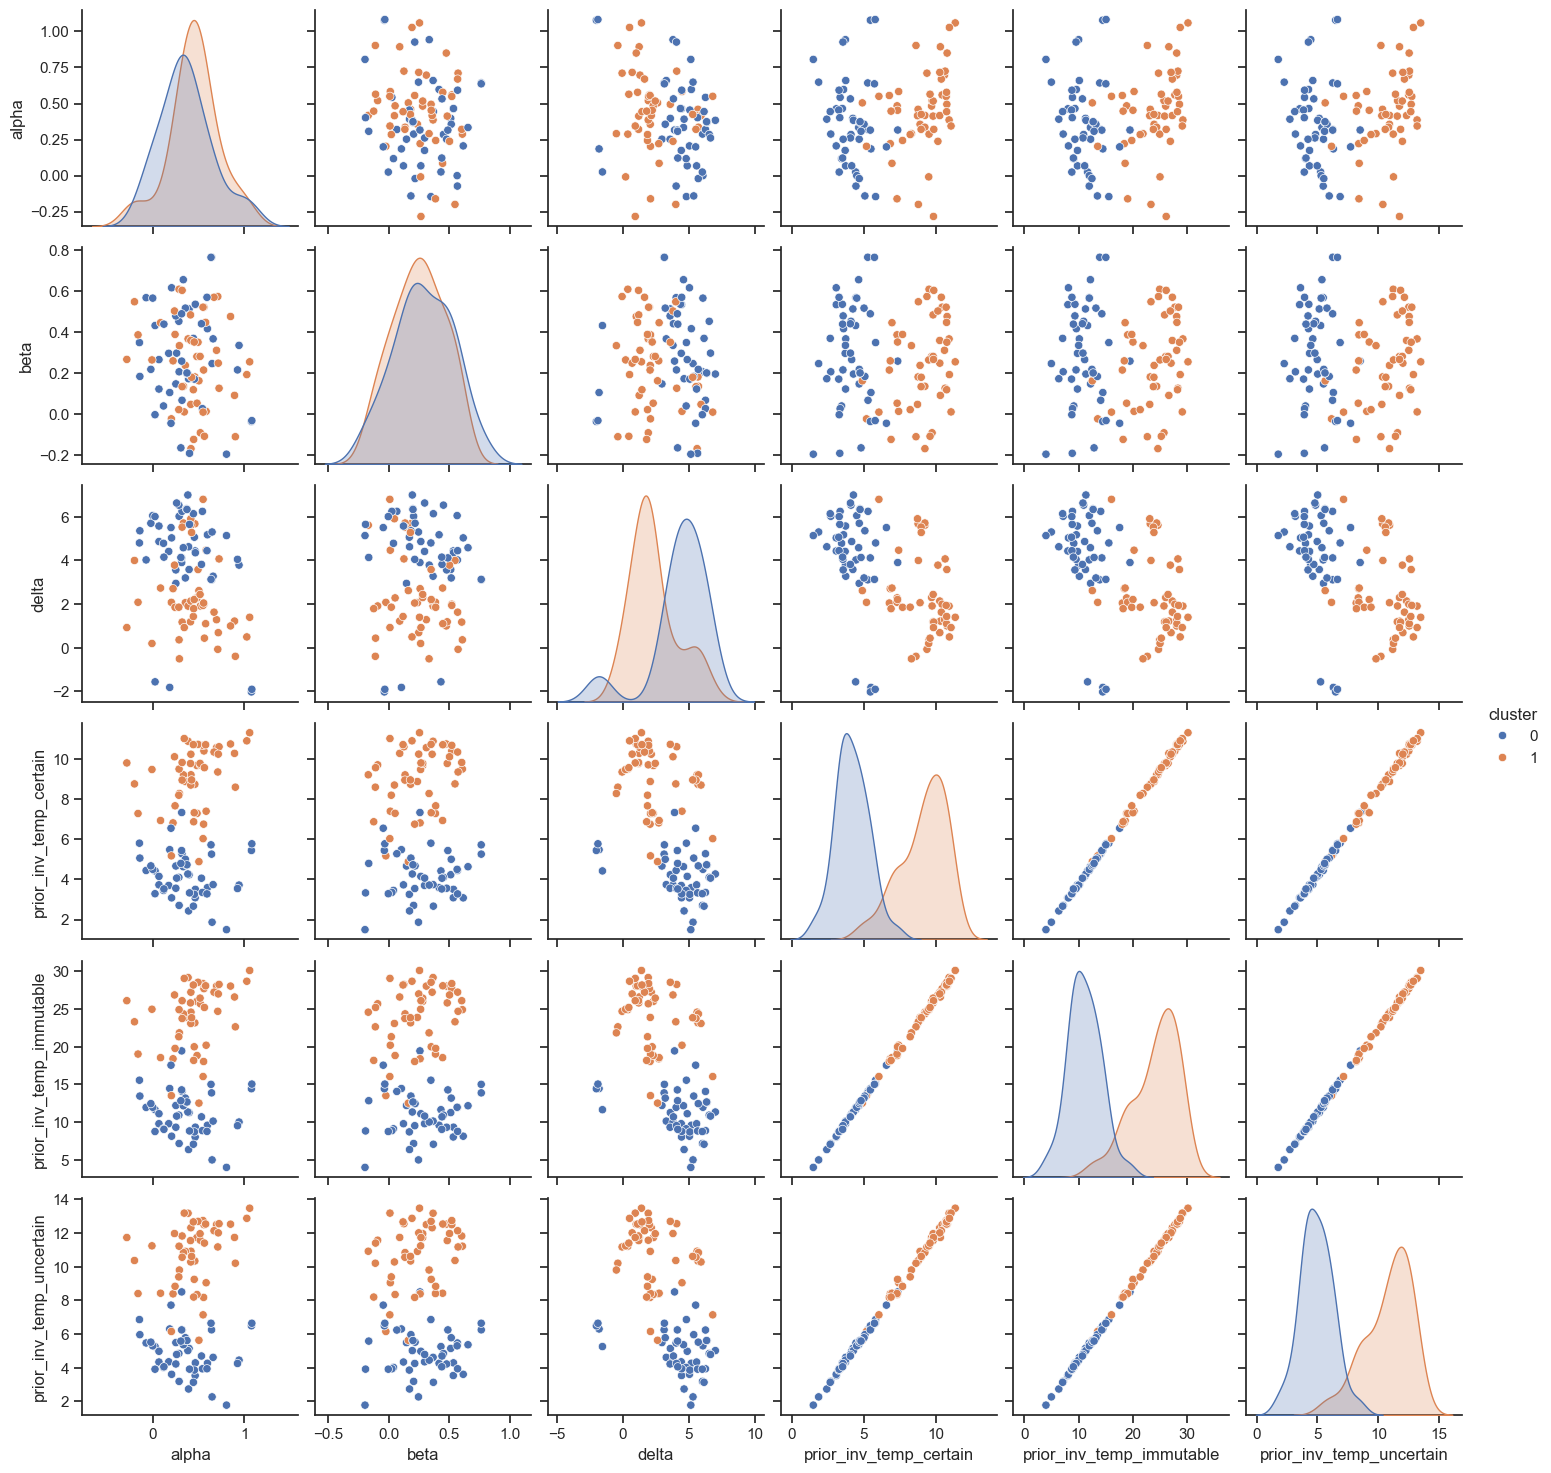

In [732]:
df_params = variants_df_params['full']
df_param_names = df_params[['part_idx', 'param_name', 'value']]
# Unmelt so that each value of param_name is a column
df_param_p = df_param_names.pivot(columns='param_name', index='part_idx', values='value')

gm = GaussianMixture(n_components=2, random_state=0)
gm_fit = gm.fit(df_param_p)

gm.means_

df_param_p['cluster'] = gm.predict(df_param_p)
part_cluster_1 = df_param_p[df_param_p['cluster'] == 0].index
part_cluster_2 = df_param_p[df_param_p['cluster'] == 1].index

for k, df_params in variants_df_params.items():
    df_params['cluster'] = df_params['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)

df['cluster'] = df['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)
df_long['cluster'] = df_long['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)
df_demo['cluster'] = df_demo['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)

df_long.to_csv('data/pilot/df_long_test_cluster.csv', index=False)

print('Cluster sizes: \n', df_params.groupby('cluster').part_idx.nunique())
print('Cluster means: \n', gm.means_)

# Plot all pairs of parameters distributions except alpha in df_param_p against each other
sns.pairplot(df_param_p, hue='cluster', diag_kind='kde')
plt.show()

In [735]:
df_demo.groupby('cluster').gender.value_counts(normalize=True)

cluster  gender    
0        Female        0.487179
         Male          0.487179
         Non-binary    0.025641
1        Male          0.542373
         Female        0.440678
         Non-binary    0.016949
Name: proportion, dtype: float64

# Plot probability of delivering 

In [317]:
df_long

,participant_code,intention,certainty,rigidity,intention,trust_cond,path_taken,A,B,C,D,delivered,path_hidden,path_early,certainty_lvl,trust_lvl,part_idx,cluster
5566,ivf2doqd,none,uncertain,bayesian,none,medium,A,True,False,False,False,True,False,1,1,2,54,0
5568,hh2ezh9j,none,immutable,bayesian,none,high,A,True,False,False,False,True,False,1,3,3,48,0
5569,g3l64f2k,none,uncertain,bayesian,none,low,B,False,True,False,False,True,True,2,1,1,42,1
5570,qwthoytg,none,uncertain,bayesian,none,high,A,True,False,False,False,True,False,1,1,3,74,0
5572,81qc8udv,none,immutable,bayesian,none,medium,A,True,False,False,False,True,False,1,3,2,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11093,ao87l2vz,none,certain,bayesian,none,medium,B,False,True,False,False,True,True,2,2,2,27,0
11095,96sj342h,none,immutable,bayesian,none,high,A,True,False,False,False,True,False,1,3,3,24,1
11096,n626q41f,none,certain,bayesian,none,medium,C,False,False,True,False,False,True,3,2,2,60,0
11097,cppwbnz4,none,certain,bayesian,none,high,C,False,False,True,False,False,True,3,2,3,34,1


/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/4014966985.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df_long_K, x='trust_cond', y='path_early', hue='certainty', dodge=.4, ax=ax, markers=['o', 's', 'D'], linestyles=['-', '--', '-.'], color='black', alpha=.9)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/4014966985.py:44: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.pointplot(data=df_long_K, x='trust_cond', y='delivered', hue='certainty', dodge=.4, ax=ax, markers=['o', 's', 'D'], linestyles=['-', '--', '-.'], color='black', alpha=.9)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/4014966985.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

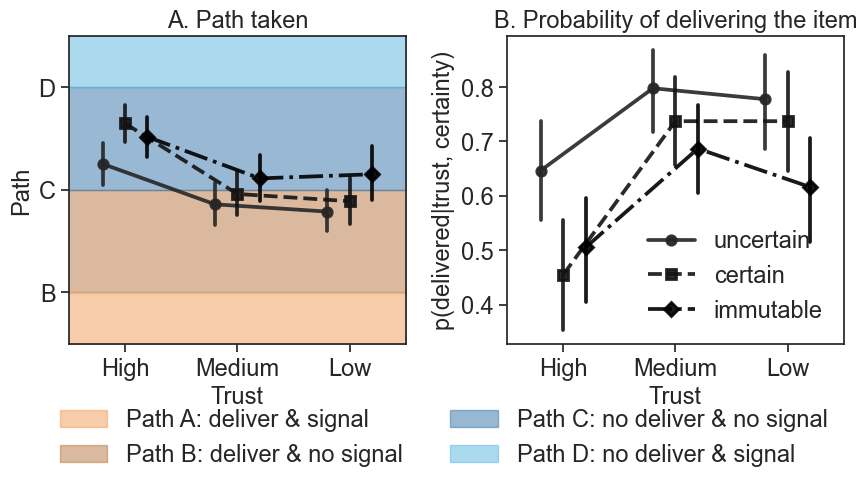

In [411]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fontsize = 17

ax = axes[0]
df_long_K = df_long.copy()
df_long_K['path_idx'] = 5 - df_long_K['path_early']
df_long_K['trust_cond'] = pd.Categorical(df_long_K['trust_cond'], categories=['high', 'medium', 'low'], ordered=True)
df_long_K['certainty'] = pd.Categorical(df_long_K['certainty'], categories=['uncertain', 'certain', 'immutable'], ordered=True)
sns.pointplot(data=df_long_K, x='trust_cond', y='path_early', hue='certainty', dodge=.4, ax=ax, markers=['o', 's', 'D'], linestyles=['-', '--', '-.'], color='black', alpha=.9)

ax.set_ylabel('Path', fontsize=fontsize)
ax.legend([], [], frameon=False)
# Set tick labels to 0: A, 1: B, 2: C, 3: D
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['A', 'B', 'C', 'D'], fontsize=fontsize)


# Fill 1 to 2 on the y axis with color path A, 2 to 3 with color path B, 3 to 4 with color path C and 4 to 5 with color path D
for i, path in enumerate(['A', 'B', 'C', 'D']):
    if path == 'A':
        label = f'Path A: deliver & signal'
    elif path == 'B':
        label = f'Path B: deliver & no signal'
    elif path == 'C':
        label = f'Path C: no deliver & no signal'
    else:
        label = f'Path D: no deliver & signal'
    ax.fill_between([-2, 5], i, i+1-.001, color=paths_colors[path], alpha=.5, label=label)
ax.set_xlim(-0.5, 2.5)
ax.set_ylim(0.5, 3.5)
handles, labels = ax.get_legend_handles_labels()
xticklabels = ['High', 'Medium', 'Low']
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(xticklabels, fontsize=fontsize)
ax.set_xlabel('Trust', fontsize=fontsize)
ax.set_title(f'A. Path taken', fontsize=fontsize)

# Probability of delivering the item
ax = axes[1]
df_long_K = df_long.copy()
df_long_K['path_idx'] = 5 - df_long_K['path_early']
df_long_K['trust_cond'] = pd.Categorical(df_long_K['trust_cond'], categories=['high', 'medium', 'low'], ordered=True)
df_long_K['certainty'] = pd.Categorical(df_long_K['certainty'], categories=['uncertain', 'certain', 'immutable'], ordered=True)
sns.pointplot(data=df_long_K, x='trust_cond', y='delivered', hue='certainty', dodge=.4, ax=ax, markers=['o', 's', 'D'], linestyles=['-', '--', '-.'], color='black', alpha=.9)

xticklabels = ['High', 'Medium', 'Low']
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(xticklabels, fontsize=fontsize)
ax.set_xlabel('Trust', fontsize=fontsize)
ax.set_title('B. Probability of delivering the item', fontsize=fontsize)

ax.set_yticklabels([np.round(tick, 1) for tick in ax.get_yticks()], fontsize=fontsize)
ax.set_ylabel('p(delivered|trust, certainty)', fontsize=fontsize)
ax.legend(fontsize=fontsize, frameon=False)

# Create legend at the bottom center
fig.legend(handles[3:], labels[3:], loc='lower center', ncol=2, fontsize=fontsize, bbox_to_anchor=(0.5, -.25), frameon=False)   
    
plt.subplots_adjust(wspace=0.3)

plt.savefig('figures/mixed_effect_results_all.pdf', dpi=500, bbox_inches='tight')


/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2649748767.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_long_K = df_long[(df['cluster'] == k)]
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2649748767.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long_K['path_idx'] = 5 - df_long_K['path_early']
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2649748767.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

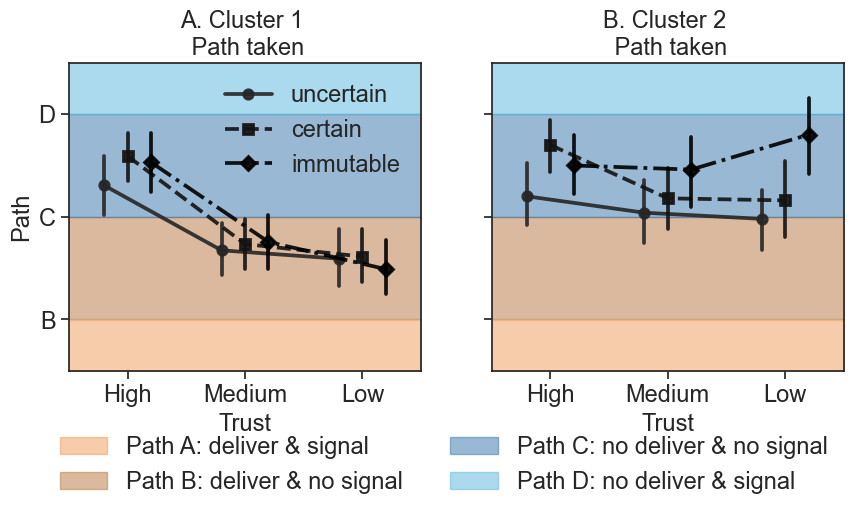

In [409]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fontsize = 17

titles = ['A.', 'B.']
for k in range(2):
    ax = axes[k]
    
    df_long_K = df_long[(df['cluster'] == k)]
    df_long_K['path_idx'] = 5 - df_long_K['path_early']
    df_long_K['trust_cond'] = pd.Categorical(df_long_K['trust_cond'], categories=['high', 'medium', 'low'], ordered=True)
    df_long_K['certainty'] = pd.Categorical(df_long_K['certainty'], categories=['uncertain', 'certain', 'immutable'], ordered=True)
    sns.pointplot(data=df_long_K, x='trust_cond', y='path_early', hue='certainty', dodge=.4, ax=ax, markers=['o', 's', 'D'], linestyles=['-', '--', '-.'], color='black', alpha=.9)
    if k == 0:
        ax.set_ylabel('Path', fontsize=fontsize)
        ax.legend(fontsize=fontsize, frameon=False)

        # Set tick labels to 0: A, 1: B, 2: C, 3: D
        ax.set_yticks([0, 1, 2, 3])
        ax.set_yticklabels(['A', 'B', 'C', 'D'], fontsize=fontsize)
    else:
        ax.set_ylabel('')
        ax.legend().remove()
    # Fill 1 to 2 on the y axis with color path A, 2 to 3 with color path B, 3 to 4 with color path C and 4 to 5 with color path D
    for i, path in enumerate(['A', 'B', 'C', 'D']):
        if path == 'A':
            label = f'Path A: deliver & signal'
        elif path == 'B':
            label = f'Path B: deliver & no signal'
        elif path == 'C':
            label = f'Path C: no deliver & no signal'
        else:
            label = f'Path D: no deliver & signal'
        ax.fill_between([-2, 5], i, i+1-.001, color=paths_colors[path], alpha=.5, label=label)
    ax.set_xlim(-0.5, 2.5)
    ax.set_ylim(0.5, 3.5)

    handles, labels = ax.get_legend_handles_labels()

    xticklabels = ['High', 'Medium', 'Low']
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(xticklabels, fontsize=fontsize)
    ax.set_xlabel('Trust', fontsize=fontsize)

    ax.set_title(f'{titles[k]} Cluster {k+1} \n Path taken', fontsize=fontsize)

# Create legend at the bottom center
fig.legend(handles[3:], labels[3:], loc='lower center', ncol=2, fontsize=fontsize, bbox_to_anchor=(0.5, -.25), frameon=False)   
    

plt.savefig('figures/mixed_effect_results_clusters.pdf', dpi=500, bbox_inches='tight')


# Parameter estimates

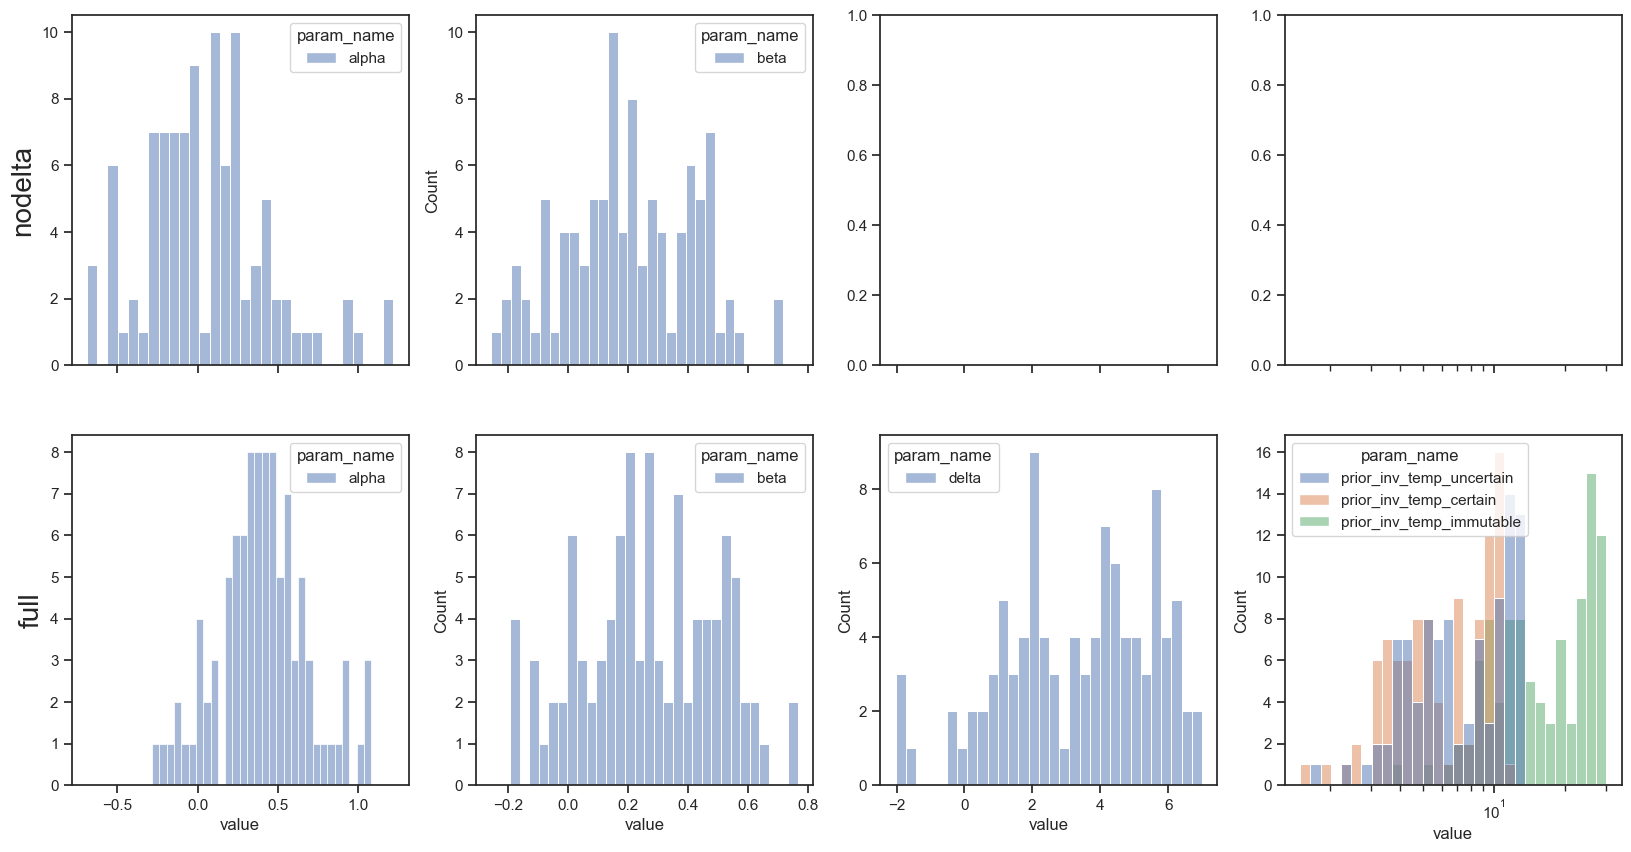

In [180]:
fig, axes = plt.subplots(len(variants), 4, figsize=(20, 10), sharex='col')


for i, variant in enumerate(variants):
    df_params = variants_df_params[variant]

    # Plot histograms for alpha, beta and delta and then weight == False with param_name as hue
    df_alpha = df_params[df_params.param_name == 'alpha']
    df_beta = df_params[df_params.param_name == 'beta']
    df_delta = df_params[df_params.param_name == 'delta']

    sns.histplot(df_alpha, x='value', hue='param_name', bins=30, ax=axes[i, 0])
    if variant not in ['nobeta', 'nobetaexp', 'onlyalpha']:
        sns.histplot(df_beta, x='value', hue='param_name', bins=30, ax=axes[i, 1])

    if variant not in ['nodelta', 'nodeltaexp', 'onlyalpha']:
        sns.histplot(df_delta, x='value', hue='param_name', bins=30, ax=axes[i, 2])

        df_inv_temp = df_params[df_params.weight == False]
        sns.histplot(df_inv_temp, x='value', hue='param_name', bins=30, ax=axes[i, 3], log_scale=True)

    axes[i, 0].set_ylabel(variant, fontsize=20)
plt.show()

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/1083971487.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inv_temp['param_name'] = df_inv_temp['param_name'].map(lambda x: x.replace('prior_inv_temp_', ''))


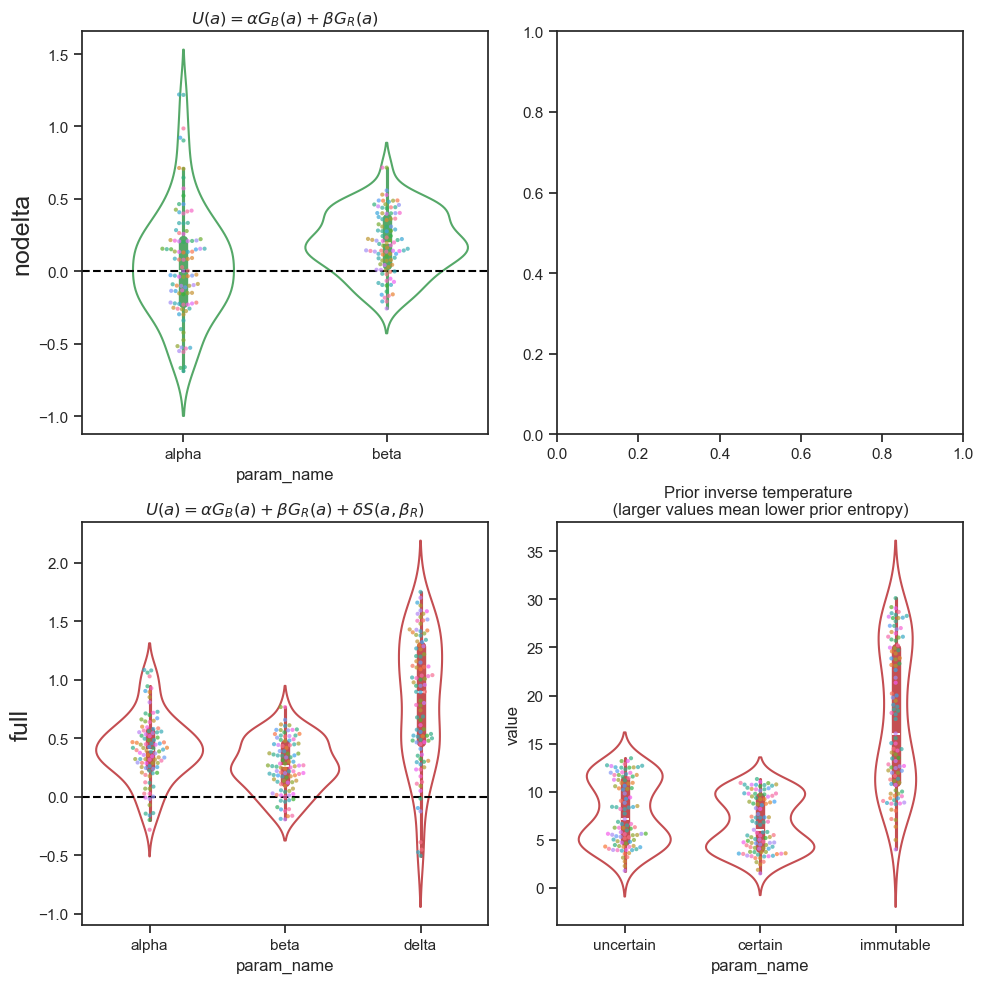

In [181]:
fig, axes = plt.subplots(len(variants), 2, figsize=(10, 10))

for i, variant in enumerate(variants):
    ax0 = axes[i, 0]
    ax1 = axes[i, 1]
    df_params = variants_df_params[variant]

    df_weight = df_params[df_params.weight == True]
    df_weight.loc[df_weight.param_name == 'delta', 'value'] = df_weight.loc[df_weight.param_name == 'delta', 'value'] / 4
    sns.swarmplot(data=df_weight, x='param_name', y='value', hue='participant_code', ax=ax0, alpha=0.7, size=3)
    sns.violinplot(data=df_weight, x='param_name', y='value', ax=ax0, fill=False)
    ax0.legend().remove()
    if 'full' in variant:
        ax0.set_title('$U(a) = \\alpha G_B(a) + \\beta G_R(a) + \\delta S(a, \\beta_R)$')
    elif 'nobeta' in variant:
        ax0.set_title('$U(a) = \\alpha G_B(a) + \\delta S(a, \\beta_R)$')
    elif 'nodelta' in variant:
        ax0.set_title('$U(a) = \\alpha G_B(a) + \\beta G_R(a)$')
    # Draw a line at 0
    ax0.axhline(0, color='black', linestyle='--')
    ax0.set_ylabel(variant, fontsize=18)

    
    if variant != 'nodelta':
        df_inv_temp = df_params[df_params.weight == False]
        df_inv_temp['param_name'] = df_inv_temp['param_name'].map(lambda x: x.replace('prior_inv_temp_', ''))
        sns.swarmplot(data=df_inv_temp, x='param_name', y='value', hue='participant_code', ax=ax1, alpha=0.7, size=3)
        sns.violinplot(data=df_inv_temp, x='param_name', y='value', ax=ax1, fill=False)
        ax1.legend().remove()
        ax1.set_title('Prior inverse temperature \n (larger values mean lower prior entropy) ')
    

plt.tight_layout()

## Parameter estimates (paper)

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2506265731.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=fontsize)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2506265731.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, fontsize=fontsize)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2506265731.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, fontsize=fontsize)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2506265731.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

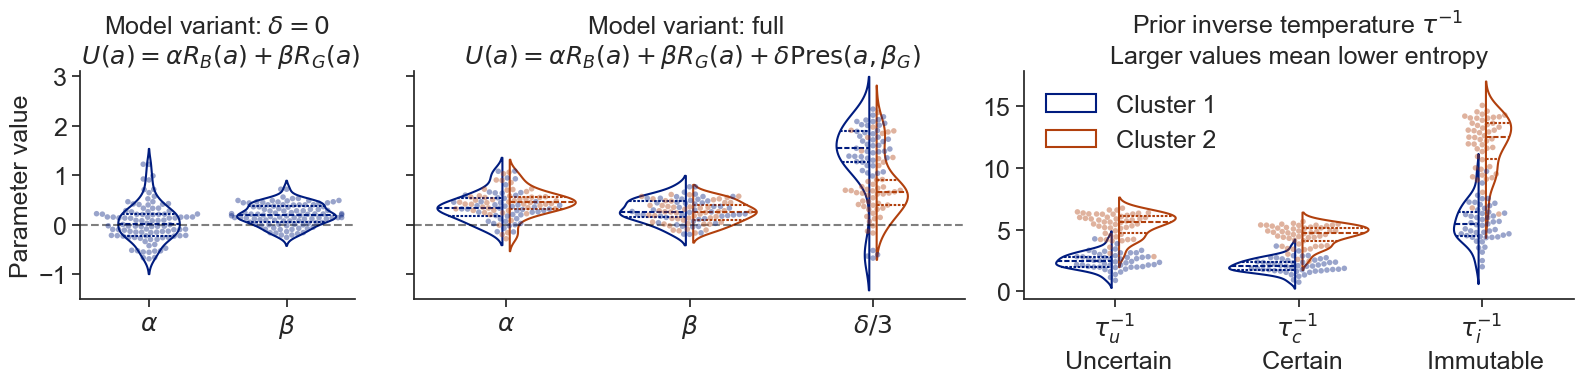

In [456]:
sns.set_theme()
sns.set_style('ticks')
sns.set_palette(sns.color_palette('dark'))

fontsize = 18
fig, axes = plt.subplots(1, 1+len(variants), figsize=(16, 4), gridspec_kw={'width_ratios': [1, 2, 2]})

idx = 0
for i, variant in enumerate(variants):
    ax = axes[idx]
    df_params = variants_df_params[variant]

    if variant not in ['full', 'nobeta', 'fullexp']:
        hue = False
        split = False
    else:
        hue = 'cluster'
        split = True

    df_weight = df_params[df_params.weight == True]
    df_weight.loc[df_weight.param_name == 'delta', 'value'] = df_weight.loc[df_weight.param_name == 'delta', 'value'] / 3
    sns.swarmplot(data=df_weight, x='param_name', y='value', hue=hue, ax=ax, alpha=0.4, size=4, dodge=False)
    sns.violinplot(data=df_weight, x='param_name', y='value', hue=hue, ax=ax, fill=False, split=split, gap=.1, inner="quart")
    ax.legend().remove()
    
    if 'full' in variant:
        ax.set_title('Model variant: full \n $U(a) = \\alpha R_B(a) + \\beta R_G(a) + \\delta \\text{Pres}(a, \\beta_G)$', fontsize=fontsize)
    elif 'nobeta' in variant:
        ax.set_title('Model variant: $\\beta = 0$ \n $U(a) = \\alpha R_B(a) + \\delta \\text{Pres}(a, \\beta_G)$', fontsize=fontsize)
    elif 'nodelta' in variant:
        ax.set_title('Model variant: $\\delta = 0$ \n $U(a) = \\alpha R_B(a) + \\beta R_G(a)$', fontsize=fontsize)
    # Draw a line at 0
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)

    ax.set_ylim(-1.5, 3.1)
    
    if idx != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Parameter value', fontsize=fontsize)
        yticklabels = ax.get_yticklabels()
        ax.set_yticklabels(yticklabels, fontsize=fontsize)

    xticklabels = ax.get_xticklabels()
    new_xticklabels = []
    for label in xticklabels:
        if label.get_text() == 'alpha':
            new_label = f'$\\alpha$'
        elif label.get_text() == 'beta':
            new_label = f'$\\beta$'
        elif label.get_text() == 'delta':
            new_label = f'$\\delta / 3$'

        new_xticklabels.append(new_label)
    ax.set_xticklabels(new_xticklabels, fontsize=fontsize)
    ax.set_xlabel('')
    
    if variant != 'nodelta':
        ax = axes[idx+1]
        df_inv_temp = df_params[df_params.weight == False]
        df_inv_temp['param_name'] = df_inv_temp['param_name'].map(lambda x: x.replace('prior_inv_temp_', ''))
        sns.swarmplot(data=df_inv_temp, x='param_name', y='value', hue=hue, ax=ax, alpha=0.4, size=4, dodge=False)
        sns.violinplot(data=df_inv_temp, x='param_name', y='value', hue=hue, ax=ax, fill=False, split=split, gap=.1, inner="quart")
        
        # Keep two last handles from legend and rename them Cluster 1 and Cluster 2
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[-2:]
        labels = ['Cluster 1', 'Cluster 2']
        ax.legend(handles, labels, fontsize=fontsize, frameon=False)
        
        ax.set_title('Prior inverse temperature $\\tau^{-1}$ \n Larger values mean lower entropy ', fontsize=fontsize)
        
        ax.set_ylabel('')
        yticklabels = ax.get_yticklabels()
        ax.set_yticklabels(yticklabels, fontsize=fontsize)
        

        # Rename xticks by capitalising first letter and adding "$\tau^{-1}_{fist_letter}$ \n" at the beginning
        xticklabels = ax.get_xticklabels()
        new_xticklabels = []
        for label in xticklabels:
            new_label = f'$\\tau^{{-1}}_{{{label.get_text()[0]}}}$ \n {label.get_text().capitalize()}'
            new_xticklabels.append(new_label)
        ax.set_xticklabels(new_xticklabels, fontsize=fontsize)
        
        ax.set_xlabel('')


    idx += 1  
    
sns.despine()
plt.tight_layout()

plt.savefig('figures/parameters_posterior.pdf', dpi=500, bbox_inches='tight')

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/331639710.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=fontsize)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/331639710.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, fontsize=fontsize)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/331639710.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_xticklabels, fontsize=fontsize)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/331639710.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

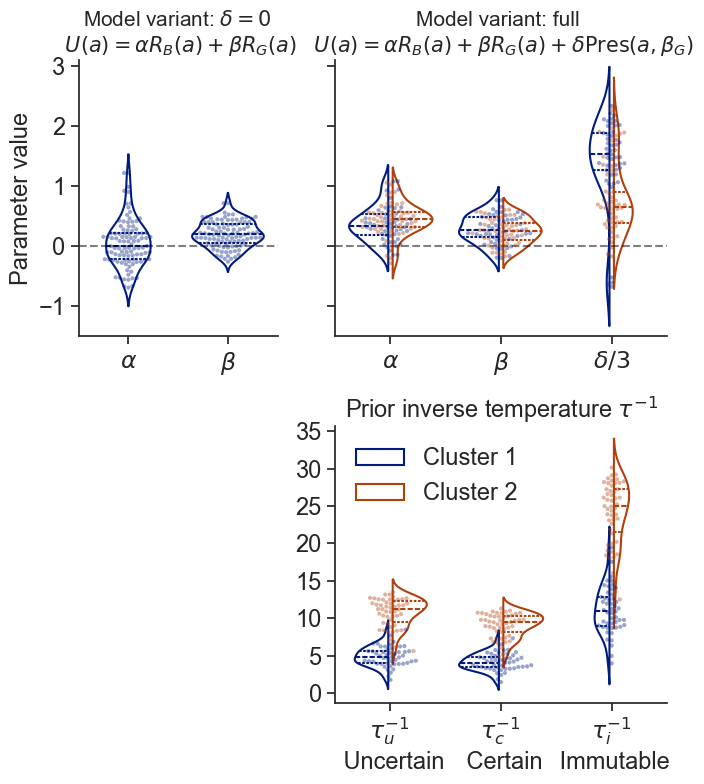

In [457]:
sns.set_theme()
sns.set_style('ticks')
sns.set_palette(sns.color_palette('dark'))

fontsize = 17
fig, axes = plt.subplots(2, len(variants), figsize=(7, 8), 
                         gridspec_kw={'width_ratios': [1.2, 2]}
                         )

for j in range(2):
    ax = axes[0, j]
    variant = variants[j]
    df_params = variants_df_params[variant]

    if variant not in ['full', 'nobeta', 'fullexp']:
        hue = False
        split = False
    else:
        hue = 'cluster'
        split = True

    df_weight = df_params[df_params.weight == True]
    df_weight.loc[df_weight.param_name == 'delta', 'value'] = df_weight.loc[df_weight.param_name == 'delta', 'value'] / 3
    sns.swarmplot(data=df_weight, x='param_name', y='value', hue=hue, ax=ax, alpha=0.4, size=3, dodge=False)
    sns.violinplot(data=df_weight, x='param_name', y='value', hue=hue, ax=ax, fill=False, split=split, gap=.1, inner="quart")
    ax.legend().remove()
    
    if 'full' in variant:
        ax.set_title('Model variant: full \n $U(a) = \\alpha R_B(a) + \\beta R_G(a) + \\delta \\text{Pres}(a, \\beta_G)$', fontsize=fontsize-2)
    elif 'nobeta' in variant:
        ax.set_title('Model variant: $\\beta = 0$ \n $U(a) = \\alpha R_B(a) + \\delta \\text{Pres}(a, \\beta_G)$', fontsize=fontsize-2)
    elif 'nodelta' in variant:
        ax.set_title('Model variant: $\\delta = 0$ \n $U(a) = \\alpha R_B(a) + \\beta R_G(a)$', fontsize=fontsize-2)
    # Draw a line at 0
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)

    ax.set_ylim(-1.5, 3.1)
    
    if j != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Parameter value', fontsize=fontsize)
        yticklabels = ax.get_yticklabels()
        ax.set_yticklabels(yticklabels, fontsize=fontsize)

    xticklabels = ax.get_xticklabels()
    new_xticklabels = []
    for label in xticklabels:
        if label.get_text() == 'alpha':
            new_label = f'$\\alpha$'
        elif label.get_text() == 'beta':
            new_label = f'$\\beta$'
        elif label.get_text() == 'delta':
            new_label = f'$\\delta / 3$'

        new_xticklabels.append(new_label)
    ax.set_xticklabels(new_xticklabels, fontsize=fontsize)
    ax.set_xlabel('')
    
    if variant != 'nodelta':
        ax = axes[1, j]
        df_inv_temp = df_params[df_params.weight == False]
        df_inv_temp['param_name'] = df_inv_temp['param_name'].map(lambda x: x.replace('prior_inv_temp_', ''))
        sns.swarmplot(data=df_inv_temp, x='param_name', y='value', hue=hue, ax=ax, alpha=0.4, size=3, dodge=False)
        sns.violinplot(data=df_inv_temp, x='param_name', y='value', hue=hue, ax=ax, fill=False, split=split, gap=.1, inner="quart")
        
        # Keep two last handles from legend and rename them Cluster 1 and Cluster 2
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[-2:]
        labels = ['Cluster 1', 'Cluster 2']
        ax.legend(handles, labels, fontsize=fontsize, frameon=False)
        
        ax.set_title('Prior inverse temperature $\\tau^{-1}$', fontsize=fontsize)
        
        ax.set_ylabel('')
        yticklabels = ax.get_yticklabels()
        ax.set_yticklabels(yticklabels, fontsize=fontsize)
        

        # Rename xticks by capitalising first letter and adding "$\tau^{-1}_{fist_letter}$ \n" at the beginning
        xticklabels = ax.get_xticklabels()
        new_xticklabels = []
        for label in xticklabels:
            new_label = f'$\\tau^{{-1}}_{{{label.get_text()[0]}}}$ \n {label.get_text().capitalize()}'
            new_xticklabels.append(new_label)
        ax.set_xticklabels(new_xticklabels, fontsize=fontsize)
        
        ax.set_xlabel('')
    else:
        axes[1, j].axis('off')


    idx += 1  
    
sns.despine()
plt.tight_layout()

plt.savefig('figures/parameters_posterior_tight.pdf', dpi=500, bbox_inches='tight')

# Simulated data

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2946361798.py:42: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=0.5)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2946361798.py:43: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="_", markersize=25, markeredgewidth=6, linestyles='none', palette=variant_colors[variant], ax=ax)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2946361798.py:42: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=df_P_cu

['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'D']


/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2946361798.py:71: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=0.5)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2946361798.py:72: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="_", markersize=25, markeredgewidth=6, linestyles='none', palette=variant_colors[variant], ax=ax)


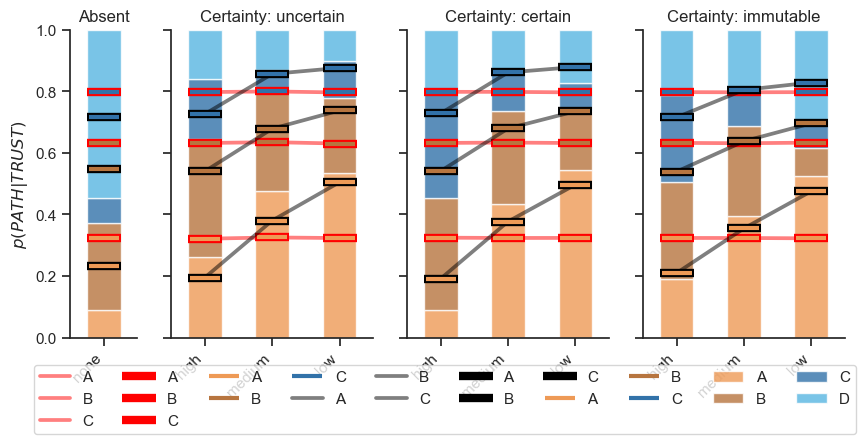

In [458]:
intentions = ['none', 'good']
interests = ['interested', 'disinterested']
#rigidities = np.sort(df.rigidity_val.dropna().unique())[::-1]
certainties = ['uncertain', 'certain', 'immutable']

trust_labels = [
    'none', 
    #'very_high', 
    'high', 
    #'slightly_high', 
    'medium', 
    #'slightly_low', 
    'low', 
    #'very_low'
]

variant_colors = {
    'full': sns.color_palette(['black']),
    'fulltemp': sns.color_palette(['orange']),
    'onlyalpha': sns.color_palette(['green']),
    'nobeta': sns.color_palette(['blue']),
    'nodelta': sns.color_palette(['red']),
}

fig, axes = plt.subplots(1, 1 + len(certainties) , figsize=(10, 4), gridspec_kw={'width_ratios': [1, 3, 3, 3]}, sharey=True)

# Plot only trials when trust == 'none'
## PLot participants
ax = axes[0]
df_paths = df[(df.block_type == 'test') & (df.trust_cond == 'none') & (df.path_taken.notna())].groupby('trust_cond').path_taken.value_counts(normalize=True)
df_paths = df_paths.unstack().reindex(trust_labels).stack()
df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=ax, alpha=0.8)


for variant in variants:
    df_Ys = variants_df_Ys[variant]
    df_paths = df_Ys[df_Ys.trust == 'none'].groupby('trust').path_taken_sim.value_counts(normalize=True).unstack().reindex(trust_labels).stack()
    df_P_cumsum = df_paths.unstack().cumsum(axis=1).stack()
    df_P_cumsum = df_P_cumsum.drop('D', level=1)
    line_styles = {'marker': 'o', 'linestyle': 'none', 'scale': 2}
    
    sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=0.5)
    sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="_", markersize=25, markeredgewidth=6, linestyles='none', palette=variant_colors[variant], ax=ax)
    sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="_", markersize=22, markeredgewidth=3, linestyles='none', palette=paths_colors, ax=ax)

# Manually change the lin
ax.set_ylim(0, 1)
# Legend and title
ax.legend().remove()
ax.set_xlabel('')
ax.set_ylabel('$p(PATH | TRUST)$')
ax.set_title('Absent')
# Rotate x labels to 45
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')



for i in range(1, len(certainties) + 1):
    certainty = certainties[i-1]
    ax = axes[i]
    df_paths = df[(df.block_type == 'test') & (df.trust_cond != 'none') & (df.path_taken.notna()) & (df.certainty == certainty)].groupby('trust_cond').path_taken.value_counts(normalize=True)
    df_paths = df_paths.unstack().reindex(trust_labels).stack()
    df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=ax, alpha=0.8)

    for variant in variants:
        df_Ys = variants_df_Ys[variant]
        df_paths = df_Ys[(df_Ys.trust != 'none') & (df_Ys.certainty == certainty)].groupby('trust').path_taken_sim.value_counts(normalize=True).unstack().reindex(trust_labels).stack()
        df_P_cumsum = df_paths.unstack().cumsum(axis=1).stack()
        df_P_cumsum = df_P_cumsum.drop('D', level=1)
        line_styles = {'marker': 'o', 'linestyle': 'none', 'scale': 2}
        sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=0.5)
        sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="_", markersize=25, markeredgewidth=6, linestyles='none', palette=variant_colors[variant], ax=ax)
        sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="_", markersize=22, markeredgewidth=3, linestyles='none', palette=paths_colors, ax=ax)

    # Manually change the lin
    ax.set_ylim(0, 1)
    # Legend and title
    ax.legend().remove()
    ax.set_xlabel('')
    ax.set_title(f'Certainty: {certainty}')

    # Rotate x labels to 45
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    



handles, labels = ax.get_legend_handles_labels()
handles_selected = handles[-4:] + handles[:-4]
labels_selected =  [f'Path {label}' for label in  labels[-4:]] + variants
# Put legend below the plot with one row and centered
fig.legend(handles, labels, loc='lower center', ncol=10, bbox_to_anchor=(0.5, -0.15))

sns.despine()

print(labels)


# Simulated data for different clusters

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/1353756185.py:65: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant] / 1.5)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/1353756185.py:66: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=11, markeredgewidth=0, linestyles='none', palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/1353756185.py:65: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may pr

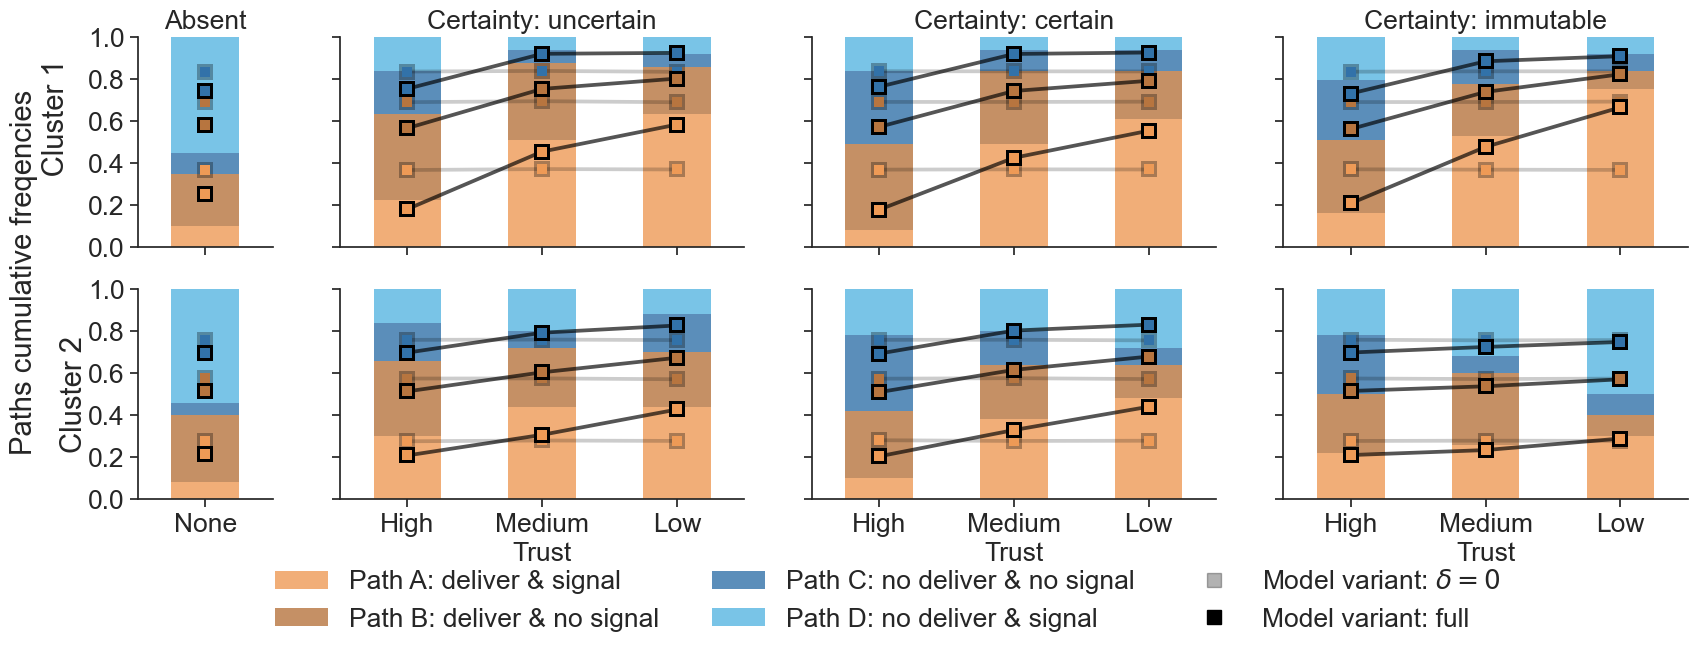

In [461]:
sns.set_theme()
sns.set_style('ticks')

fontsize = 19

part_cluster_1 = df_param_p[df_param_p.cluster == 1].index
part_cluster_0 = df_param_p[df_param_p.cluster == 0].index

intentions = ['none', 'good']
interests = ['interested', 'disinterested']
#rigidities = np.sort(df.rigidity_val.dropna().unique())[::-1]
certainties = ['uncertain', 'certain', 'immutable']

trust_labels = [
    'none', 
    #'very_high', 
    'high', 
    #'slightly_high', 
    'medium', 
    #'slightly_low', 
    'low', 
    #'very_low'
]

variant_colors = {
    'full': sns.color_palette(['black']),
    'fulltemp': sns.color_palette(['orange']),
    'onlyalpha': sns.color_palette(['green']),
    'nobeta': sns.color_palette(['blue']),
    'nodelta': sns.color_palette(['black']),
}
variants_alphas = {
    'full': 1,
    'fulltemp': 0.5,
    'onlyalpha': 0.5,
    'nobeta': 0.5,
    'nodelta': 0.3,
}

fig, axes = plt.subplots(2, 1 + len(certainties) , figsize=(20, 6), gridspec_kw={'width_ratios': [1, 3, 3, 3]}, sharey=True)


for i, part_cluster in enumerate([part_cluster_0, part_cluster_1]):
    # Plot only trials when trust == 'none'
    ## PLot participants
    ax = axes[i, 0]

    # Add participants
    df_paths = df[(df.part_idx.isin(part_cluster)) & (df.block_type == 'test') & (df.trust_cond == 'none') & (df.path_taken.notna())].groupby('trust_cond').path_taken.value_counts(normalize=True)
    df_paths = df_paths.unstack().reindex(trust_labels).stack()
    df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=ax, alpha=0.8, edgecolor='none')

    # Get legend handles and labels
    part_handles, part_labels = ax.get_legend_handles_labels()
    # Set legend as empty
    ax.legend([], [], frameon=False)

    for variant in variants:
        df_Ys = variants_df_Ys[variant]
        df_paths = df_Ys[(df_Ys.part_idx.isin(part_cluster)) & (df_Ys.trust == 'none')].groupby('trust').path_taken_sim.value_counts(normalize=True).unstack().reindex(trust_labels).stack()
        df_P_cumsum = df_paths.unstack().cumsum(axis=1).stack()
        df_P_cumsum = df_P_cumsum.drop('D', level=1)
        line_styles = {'marker': 'o', 'linestyle': 'none', 'scale': 1, 'linewidth': 0.5}

        sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant] / 1.5)
        sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=11, markeredgewidth=0, linestyles='none', palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant])
        sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=7, markeredgewidth=0, linestyles='none', palette=paths_colors, ax=ax, alpha=1)

        

    # Manually change the lin
    ax.set_ylim(0, 1)
    # Legend and title
    ax.legend().remove()
    ax.set_xlabel('')
    
    
    if i == 0:
        ax.set_title('Absent', fontsize=fontsize)
        ax.set_ylabel(f'Paths cumulative freqencies \n                                     Cluster {i+1}', fontsize=fontsize+2, labelpad=0)
        
        # Take ylabel down a bit relative to the figure
        ax.yaxis.set_label_coords(-.5, -.10)
    
    else:
        ax.set_ylabel(f'Cluster {i+1}', fontsize=fontsize+2, labelpad=0)

    # Rotate x labels to horizontal
    if i == 1:
        ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()], rotation=0, ha='center', fontsize=fontsize)
    else:
        ax.set_xticklabels([])

    yticklabels = ax.get_yticklabels()
    ax.set_yticklabels(yticklabels, fontsize=fontsize)

 



    for j in range(1, len(certainties) + 1):
        certainty = certainties[j-1]
        ax = axes[i, j]
        df_paths = df[(df.part_idx.isin(part_cluster)) & (df.block_type == 'test') & (df.trust_cond != 'none') & (df.path_taken.notna()) & (df.certainty == certainty)].groupby('trust_cond').path_taken.value_counts(normalize=True)
        df_paths = df_paths.unstack().reindex(trust_labels).stack()
        df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=ax, alpha=0.8, edgecolor='none') 

        for variant in variants:
            df_Ys = variants_df_Ys[variant]
            df_paths = df_Ys[(df_Ys.part_idx.isin(part_cluster)) & (df_Ys.trust != 'none') & (df_Ys.certainty == certainty)].groupby('trust').path_taken_sim.value_counts(normalize=True).unstack().reindex(trust_labels).stack()
            df_P_cumsum = df_paths.unstack().cumsum(axis=1).stack()
            # Check if D is in the index and drop it
            if 'D' in df_P_cumsum.index.get_level_values(1):
                df_P_cumsum = df_P_cumsum.drop('D', level=1)
            line_styles = {'marker': 'o', 'linestyle': 'none', 'scale': 1, 'linewidth': 0.5}

            sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant] / 1.5)
            sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=11, markeredgewidth=0, linestyles='none', palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant])
            sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=7, markeredgewidth=0, linestyles='none', palette=paths_colors, ax=ax, alpha=1)

        # Manually change the lin
        ax.set_ylim(0, 1)
        # Legend and title
        ax.legend().remove()
        if i == 1:
            ax.set_xlabel('Trust', fontsize=fontsize)
        else:
            ax.set_xlabel('')

        if i == 0:
            ax.set_title(f'Certainty: {certainty}', fontsize=fontsize)

        # Rotate x labels to 45
        if i == 1:
            ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()], rotation=0, ha='center', fontsize=fontsize)
        else:
            ax.set_xticklabels([])


# Create legend with participant labels and handles and add labels for the model variants and colors from variant_colors
# Model handels 
model_handles = []
model_labels = []
for variant in variants:
    handle = mlines.Line2D([], [], color=variant_colors[variant][0], marker='s', linestyle='None',
                          markersize=10, label='Squares', alpha=variants_alphas[variant])
    model_handles.append(handle)

    if variant == 'full':
        label = 'Model variant: full'
    elif variant == 'nodelta':
        label = 'Model variant: $\\delta = 0$'
    model_labels.append(label)


handles = part_handles + model_handles

path_labels_detailed = []
for path in part_labels:
    if path == 'A':
        label = 'Path A: deliver & signal'
    elif path == 'B':
        label = 'Path B: deliver & no signal'
    elif path == 'C':
        label = 'Path C: no deliver & no signal'
    elif path == 'D':
        label = 'Path D: no deliver & signal'
    path_labels_detailed.append(label)
labels = path_labels_detailed + model_labels



fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -.15), fontsize=fontsize, frameon=False)
sns.despine()

plt.subplots_adjust(hspace=0.2)

#plt.tight_layout()

plt.savefig('figures/paths_cumulative.pdf', dpi=500, bbox_inches='tight')


/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2515135281.py:65: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant] / 1.5)
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2515135281.py:66: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=11, markeredgewidth=0, linestyles='none', palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant])
/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/2515135281.py:65: UserWarning: 
The palette list has fewer values (1) than needed (3) and will cycle, which may pr

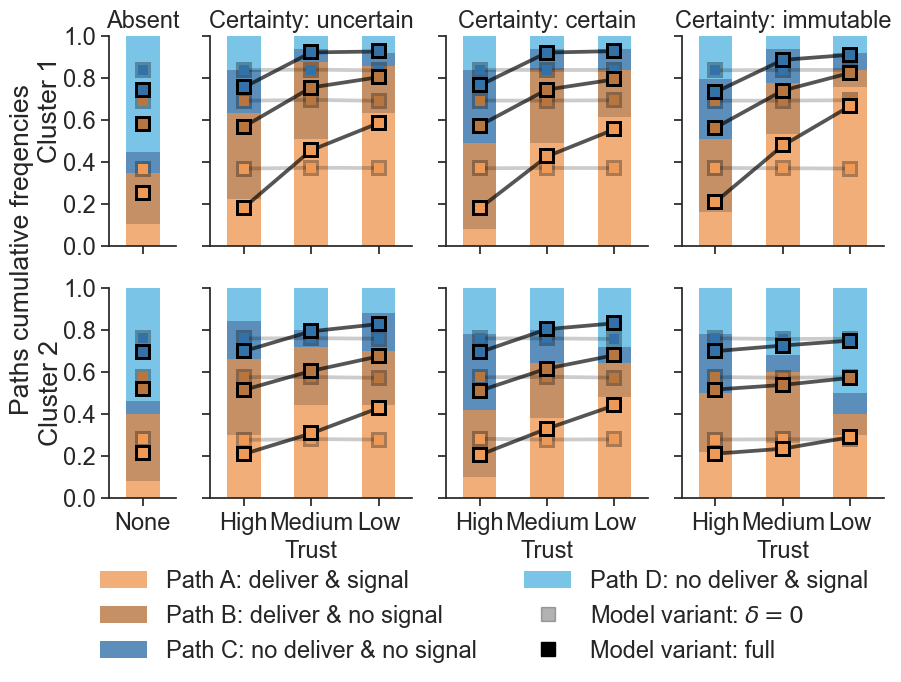

In [460]:
sns.set_theme()
sns.set_style('ticks')

fontsize = 17

part_cluster_1 = df_param_p[df_param_p.cluster == 1].index
part_cluster_0 = df_param_p[df_param_p.cluster == 0].index

intentions = ['none', 'good']
interests = ['interested', 'disinterested']
#rigidities = np.sort(df.rigidity_val.dropna().unique())[::-1]
certainties = ['uncertain', 'certain', 'immutable']

trust_labels = [
    'none', 
    #'very_high', 
    'high', 
    #'slightly_high', 
    'medium', 
    #'slightly_low', 
    'low', 
    #'very_low'
]

variant_colors = {
    'full': sns.color_palette(['black']),
    'fulltemp': sns.color_palette(['orange']),
    'onlyalpha': sns.color_palette(['green']),
    'nobeta': sns.color_palette(['blue']),
    'nodelta': sns.color_palette(['black']),
}
variants_alphas = {
    'full': 1,
    'fulltemp': 0.5,
    'onlyalpha': 0.5,
    'nobeta': 0.5,
    'nodelta': 0.3,
}

fig, axes = plt.subplots(2, 1 + len(certainties) , figsize=(10, 6), gridspec_kw={'width_ratios': [1, 3, 3, 3]}, sharey=True)


for i, part_cluster in enumerate([part_cluster_0, part_cluster_1]):
    # Plot only trials when trust == 'none'
    ## PLot participants
    ax = axes[i, 0]

    # Add participants
    df_paths = df[(df.part_idx.isin(part_cluster)) & (df.block_type == 'test') & (df.trust_cond == 'none') & (df.path_taken.notna())].groupby('trust_cond').path_taken.value_counts(normalize=True)
    df_paths = df_paths.unstack().reindex(trust_labels).stack()
    df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=ax, alpha=0.8, edgecolor='none')

    # Get legend handles and labels
    part_handles, part_labels = ax.get_legend_handles_labels()
    # Set legend as empty
    ax.legend([], [], frameon=False)

    for variant in variants:
        df_Ys = variants_df_Ys[variant]
        df_paths = df_Ys[(df_Ys.part_idx.isin(part_cluster)) & (df_Ys.trust == 'none')].groupby('trust').path_taken_sim.value_counts(normalize=True).unstack().reindex(trust_labels).stack()
        df_P_cumsum = df_paths.unstack().cumsum(axis=1).stack()
        df_P_cumsum = df_P_cumsum.drop('D', level=1)
        line_styles = {'marker': 'o', 'linestyle': 'none', 'scale': 1, 'linewidth': 0.5}

        sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant] / 1.5)
        sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=11, markeredgewidth=0, linestyles='none', palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant])
        sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=7, markeredgewidth=0, linestyles='none', palette=paths_colors, ax=ax, alpha=1)

        

    # Manually change the lin
    ax.set_ylim(0, 1)
    # Legend and title
    ax.legend().remove()
    ax.set_xlabel('')
    
    
    if i == 0:
        ax.set_title('Absent', fontsize=fontsize)
        ax.set_ylabel(f'Paths cumulative freqencies \n                                     Cluster {i+1}', fontsize=fontsize+2, labelpad=0)
        
        # Take ylabel down a bit relative to the figure
        ax.yaxis.set_label_coords(-.7, 0)
    
    else:
        ax.set_ylabel(f'Cluster {i+1}', fontsize=fontsize+2, labelpad=0)

    # Rotate x labels to horizontal
    if i == 1:
        ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()], rotation=0, ha='center', fontsize=fontsize)
    else:
        ax.set_xticklabels([])

    yticklabels = ax.get_yticklabels()
    ax.set_yticklabels(yticklabels, fontsize=fontsize)

 



    for j in range(1, len(certainties) + 1):
        certainty = certainties[j-1]
        ax = axes[i, j]
        df_paths = df[(df.part_idx.isin(part_cluster)) & (df.block_type == 'test') & (df.trust_cond != 'none') & (df.path_taken.notna()) & (df.certainty == certainty)].groupby('trust_cond').path_taken.value_counts(normalize=True)
        df_paths = df_paths.unstack().reindex(trust_labels).stack()
        df_paths.unstack().plot(kind='bar', stacked=True, color=paths_colors, ax=ax, alpha=0.8, edgecolor='none') 

        for variant in variants:
            df_Ys = variants_df_Ys[variant]
            df_paths = df_Ys[(df_Ys.part_idx.isin(part_cluster)) & (df_Ys.trust != 'none') & (df_Ys.certainty == certainty)].groupby('trust').path_taken_sim.value_counts(normalize=True).unstack().reindex(trust_labels).stack()
            df_P_cumsum = df_paths.unstack().cumsum(axis=1).stack()
            # Check if D is in the index and drop it
            if 'D' in df_P_cumsum.index.get_level_values(1):
                df_P_cumsum = df_P_cumsum.drop('D', level=1)
            line_styles = {'marker': 'o', 'linestyle': 'none', 'scale': 1, 'linewidth': 0.5}

            sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', markers=None, palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant] / 1.5)
            sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=11, markeredgewidth=0, linestyles='none', palette=variant_colors[variant], ax=ax, alpha=variants_alphas[variant])
            sns.pointplot(data=df_P_cumsum.reset_index(), x='trust', y=0, hue='path_taken_sim', marker="s", markersize=7, markeredgewidth=0, linestyles='none', palette=paths_colors, ax=ax, alpha=1)

        # Manually change the lin
        ax.set_ylim(0, 1)
        # Legend and title
        ax.legend().remove()
        if i == 1:
            ax.set_xlabel('Trust', fontsize=fontsize)
        else:
            ax.set_xlabel('')

        if i == 0:
            ax.set_title(f'Certainty: {certainty}', fontsize=fontsize)

        # Rotate x labels to 45
        if i == 1:
            ax.set_xticklabels([label.get_text().capitalize() for label in ax.get_xticklabels()], rotation=0, ha='center', fontsize=fontsize)
        else:
            ax.set_xticklabels([])


# Create legend with participant labels and handles and add labels for the model variants and colors from variant_colors
# Model handels 
model_handles = []
model_labels = []
for variant in variants:
    handle = mlines.Line2D([], [], color=variant_colors[variant][0], marker='s', linestyle='None',
                          markersize=10, label='Squares', alpha=variants_alphas[variant])
    model_handles.append(handle)

    if variant == 'full':
        label = 'Model variant: full'
    elif variant == 'nodelta':
        label = 'Model variant: $\\delta = 0$'
    model_labels.append(label)


handles = part_handles + model_handles

path_labels_detailed = []
for path in part_labels:
    if path == 'A':
        label = 'Path A: deliver & signal'
    elif path == 'B':
        label = 'Path B: deliver & no signal'
    elif path == 'C':
        label = 'Path C: no deliver & no signal'
    elif path == 'D':
        label = 'Path D: no deliver & signal'
    path_labels_detailed.append(label)
labels = path_labels_detailed + model_labels



fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -.2), fontsize=fontsize, frameon=False)
sns.despine()

plt.subplots_adjust(hspace=0.2)

#plt.tight_layout()

plt.savefig('figures/paths_cumulative_tight.pdf', dpi=500, bbox_inches='tight')


## Compute correlation between model and behavioural data for all conditions


### Model variants

- Full
- No presentational
- No prosocial


In [542]:
variants = [
    'nodelta',
    'full',
    #'onlyalpha',
    'nobeta'
    #'fullexp',
    #'nobetaexp',
    #'nodeltaexp'   
]

# Load data
variants_df_params_full = {}
variants_df_params = {}
variants_df_Ys = {}
variants_df_Ys_nobeta = {}
variants_fit = {}
for variant in variants:
    df_params_full = pd.read_csv(f'stan_files/tom_model_basic_{variant}_params.csv')
    variants_df_params[variant] = df_params_full

    df_params = df_params_full.groupby(['part_idx', 'participant_code', 'weight', 'param_code', 'param_name']).value.mean().reset_index()
    variants_df_params[variant] = df_params
    
    df_Ys = pd.read_csv(f'stan_files/tom_model_basic_{variant}_y_sim.csv')
    variants_df_Ys[variant] = df_Ys

    #df_Ys_nobeta = pd.read_csv(f'stan_files/tom_model_basic_{variant}_y_nobeta_sim.csv')
    #variants_df_Ys_nobeta[variant] = df_Ys_nobeta

    # Load Stan fit object
    with open(f'stan_files/tom_model_basic_{variant}_fit.pkl', 'rb') as f:
        fit = pickle.load(f)

    variants_fit[variant] = fit

/var/folders/hh/c12d0kb97ln3mqms4k45kqwm0000gn/T/ipykernel_52181/937948390.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = df['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)


Cluster sizes: 
 cluster
0    49
1    50
Name: part_idx, dtype: int64
Cluster means: 
 [[ 0.36979028  0.28909025  4.3478767   4.17414668 11.05811244  4.91777298]
 [ 0.44277959  0.2473035   2.31071274  9.0560295  23.97873976 10.7544003 ]]


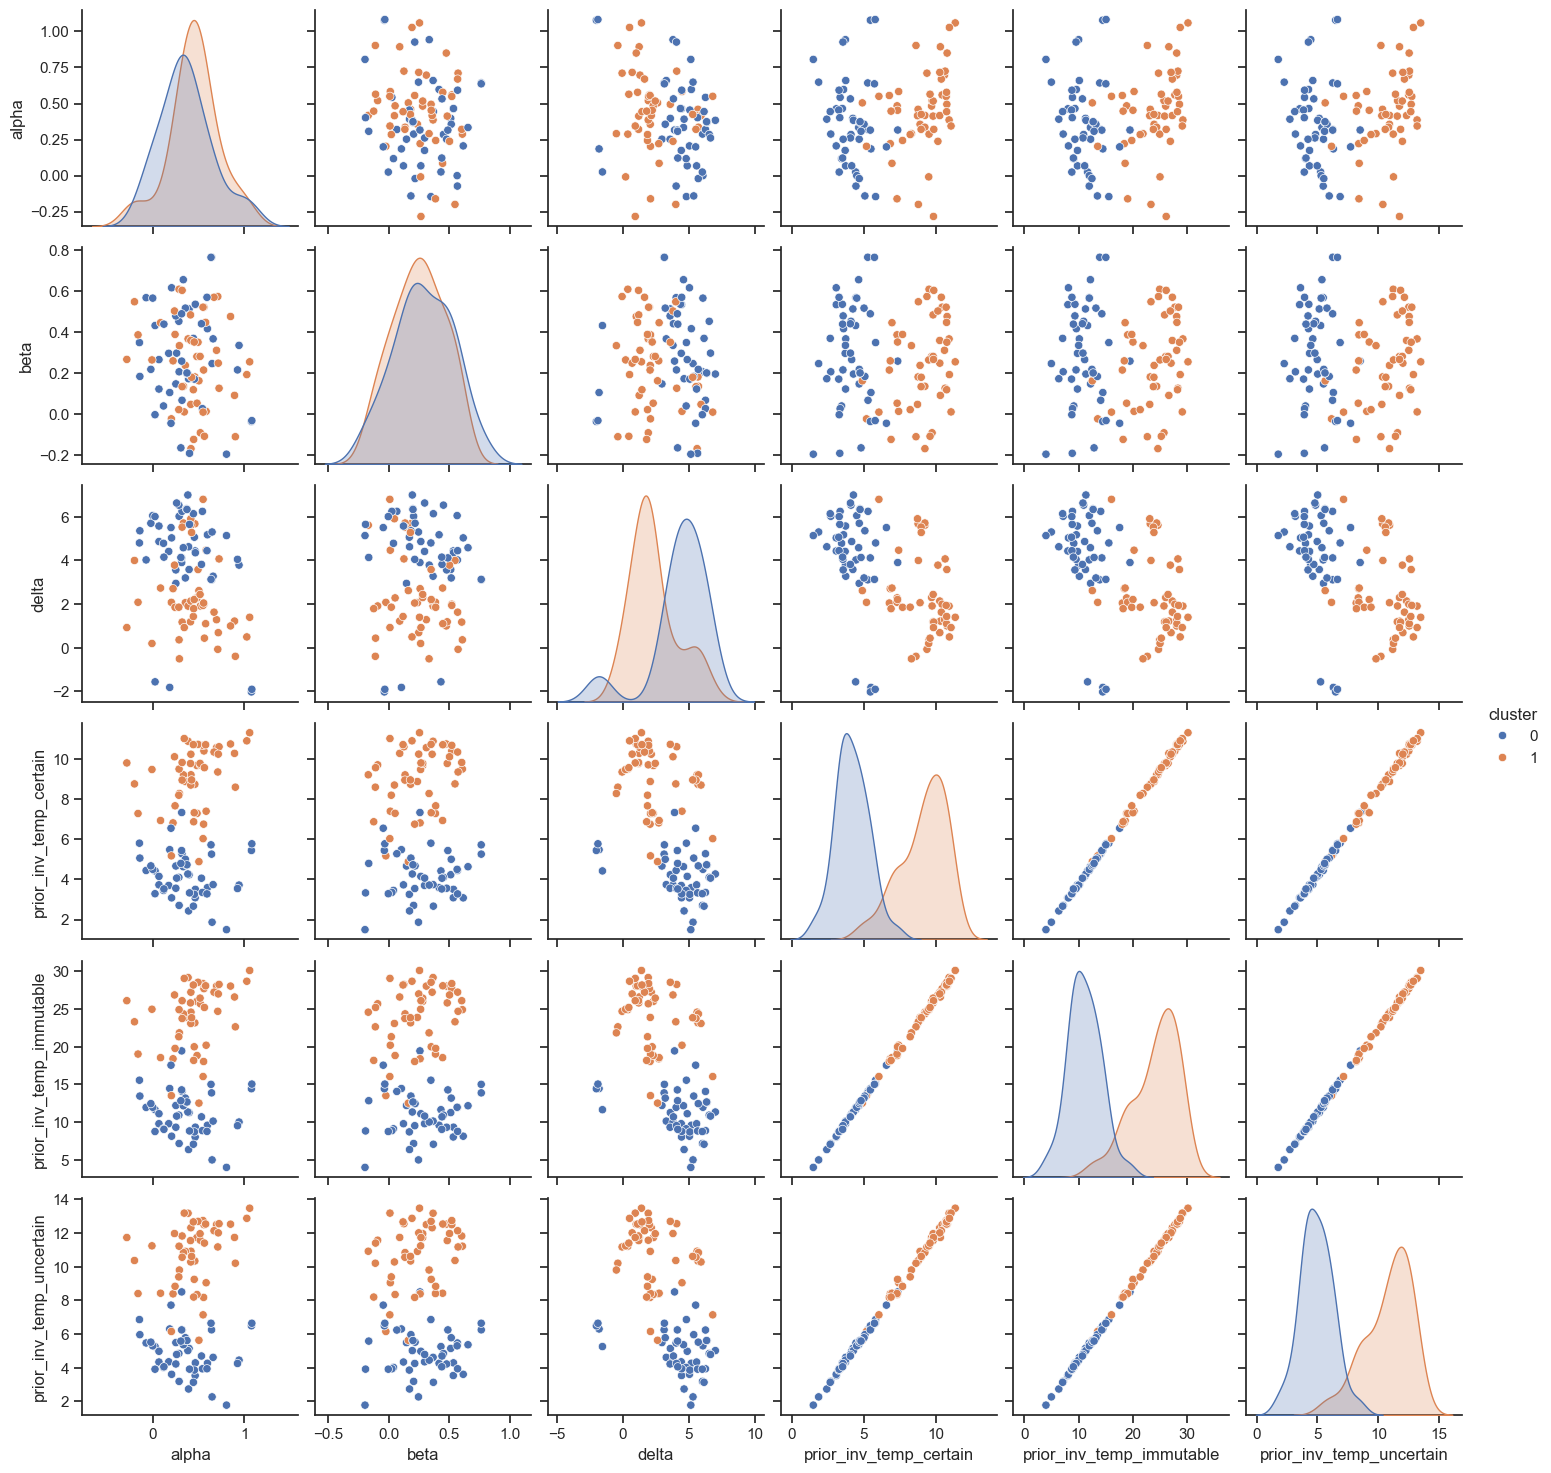

In [566]:
df_params = variants_df_params['full']
df_param_names = df_params[['part_idx', 'param_name', 'value']]
# Unmelt so that each value of param_name is a column
df_param_p = df_param_names.pivot(columns='param_name', index='part_idx', values='value')

gm = GaussianMixture(n_components=2, random_state=0)
gm_fit = gm.fit(df_param_p)

gm.means_

df_param_p['cluster'] = gm.predict(df_param_p)
part_cluster_1 = df_param_p[df_param_p['cluster'] == 0].index
part_cluster_2 = df_param_p[df_param_p['cluster'] == 1].index

for k, df_params in variants_df_params.items():
    df_params['cluster'] = df_params['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)

for k, df_Ys in variants_df_Ys.items():
    df_Ys['cluster'] = df_Ys['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)
    
df['cluster'] = df['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)
df_long['cluster'] = df_long['part_idx'].map(lambda x: 0 if x in part_cluster_1 else 1)

print('Cluster sizes: \n', df_params.groupby('cluster').part_idx.nunique())
print('Cluster means: \n', gm.means_)

# Plot all pairs of parameters distributions except alpha in df_param_p against each other
sns.pairplot(df_param_p, hue='cluster', diag_kind='kde')
plt.show()

In [ ]:
participants = df.participant_code.unique()

col_order = ['certainty_lvl', 'trust_lvl', 'path_idx']
col_order_M = ['certainty_lvl', 'trust_lvl', 'path_idx_sim']

cases = [
    'part',
    *variants,
    'random'
]
N_samples = 400
M_bootstrap = 99
bootstrap_full = np.zeros((N_samples, len(cases), 990))
bootstrap_full_corr = np.zeros((N_samples, len(cases), len(cases)))
bootstrap_full_r2 = np.zeros((N_samples, len(cases), len(cases)))
bootstrap_output = np.zeros((N_samples, len(cases), 36))
bootstrap_corr = np.zeros((N_samples, len(cases), len(cases)))
bootstrap_r2 = np.zeros((N_samples, len(cases), len(cases)))

observed = True

i = 0
failed = 0
while i < N_samples:

    sample = np.random.choice(participants, M_bootstrap, replace=True)
    unique_ids_values = pd.Series(sample).value_counts()

    # Participant data
    part_data = []

    for code, num in zip(unique_ids_values.index, unique_ids_values.values):
        # Participant data
        part_arr = df[(df.block_type == 'test') & (df.participant_code == code) & (df.path_taken.notna())][col_order].to_numpy()
        part_data += [part_arr for _ in range(num)]
    part_data = np.concatenate(part_data)
    df_P = pd.DataFrame(part_data, columns=col_order)
    #df_P['path_idx'] = pd.Categorical(df_P.path_idx, categories=[1, 2, 3, 4], ordered=True)
    #df_P.sort_values(col_order[:-1], inplace=True)

    bootstrap_full[i, 0, :] = df_P.path_idx

    df_P_bs = df_P.groupby(col_order[:-1], observed=observed).path_idx.value_counts(normalize=True)
    df_P_bs = df_P_bs.reindex([1, 2, 3, 4], level=2).fillna(0)
    # Reindex to have all paths
    
    bs_P_freqs = df_P_bs.values

    try:
        bootstrap_output[i, 0, :] = bs_P_freqs
    except:
        failed += 1
        continue

    # Random data
    df_R = pd.DataFrame(part_data, columns=col_order)
    df_R['path_idx'] = np.random.choice([1, 2, 3, 4], df_R.shape[0])
    #df_R['path_idx'] = pd.Categorical(df_P.path_idx, categories=[1, 2, 3, 4], ordered=True)
    #df_R.sort_values(col_order[:-1], inplace=True)

    bootstrap_full[i, -1, :] = df_R.path_idx

    df_R_bs = df_R.groupby(col_order[:-1], observed=observed).path_idx.value_counts(normalize=True)
    bs_R_freqs = df_R_bs.values

    bootstrap_output[i, -1, :] = bs_R_freqs

    # Model data
    for j, variant in enumerate(variants):
        df_Ys = variants_df_Ys[variant]
        sim_idx = np.random.choice(df_Ys.sim_idx.unique())
        
        df_Ys_selected = df_Ys[(df_Ys.sim_idx == sim_idx)][col_order_M].to_numpy()
        df_M = pd.DataFrame(df_Ys_selected, columns=col_order)
        #df_M['path_idx'] = pd.Categorical(df_P.path_idx, categories=[1, 2, 3, 4], ordered=True)
        #df_M.sort_values(col_order[:-1], inplace=True)
        bootstrap_full[i, j+1, :] = df_M.path_idx

        df_M_bs = df_M.groupby(col_order[:-1], observed=observed).path_idx.value_counts(normalize=True)
        # Reinex to have all paths
        df_M_bs = df_M_bs.reindex([1, 2, 3, 4], level=2).fillna(0)
        bs_M_freqs = df_M_bs.values

        bootstrap_output[i, j+1, :] = bs_M_freqs
        
    # Compute pairwise correlations
    for j in range(len(cases)):
        for k in range(len(cases)):
            bootstrap_full_corr[i, j, k] = stats.pearsonr(bootstrap_full[i, j, :], bootstrap_full[i, k, :])[0]
            bootstrap_corr[i, j, k] = stats.pearsonr(bootstrap_output[i, j, :], bootstrap_output[i, k, :])[0]
            bootstrap_r2[i, j, k] = bootstrap_corr[i, j, k] ** 2
            bootstrap_full_r2[i, j, k] = bootstrap_full_corr[i, j, k] ** 2

    if i % 20 == 0:
        print(f'Sample {i+1} done')
    
    i += 1

print(f'Failed {failed} samples')

Sample 1 done
Sample 21 done
Sample 41 done
Sample 61 done
Sample 81 done
Sample 101 done
Sample 121 done
Sample 141 done
Sample 161 done
Sample 181 done
Sample 201 done
Sample 221 done
Sample 241 done
Sample 261 done
Sample 281 done
Sample 301 done
Sample 321 done
Sample 341 done
Sample 361 done
Sample 381 done
Failed 0 samples


In [559]:
(df_M_bs.reset_index().to_numpy()[:, :-1] != df_P_bs.reset_index().to_numpy()[:, :-1]).sum()

0

In [562]:
# Remove trust_lvl 4
df_M_bs.reindex([1, 2, 3], level=1).fillna(0)

36

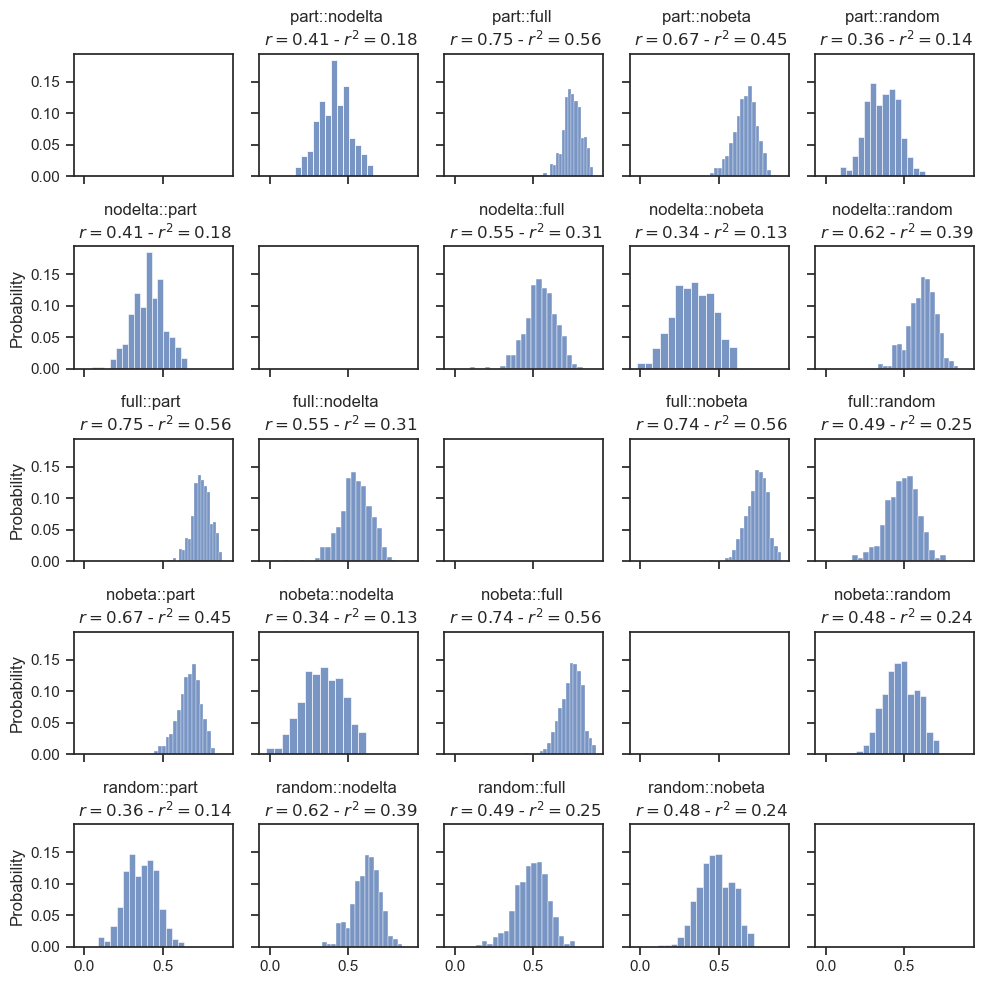

In [553]:
fig, axes = plt.subplots(len(cases), len(cases), figsize=(10, 10), sharex=True, sharey=True)

for i in range(len(cases)):
    for j in range(len(cases)):
        if i == j:
            continue
        ax = axes[i, j]

        sns.histplot(bootstrap_corr[:, i, j], ax=ax, stat='probability')

        rowname = cases[i]
        colname = cases[j]

        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(bootstrap_output[0, i, :], bootstrap_output[0, j, :])
        

        ax.set_title(f'{rowname}::{colname} \n $r={(bootstrap_corr[:, i, j].mean()).round(2)}$ - $r^2={(bootstrap_r2[:, i, j].mean()).round(2)}$')


plt.tight_layout()

In [563]:
participants = df.participant_code.unique()

col_order = ['certainty_lvl', 'trust_lvl', 'path_idx']
col_order_M = ['certainty_lvl', 'trust_lvl', 'path_idx_sim']

cases = [
    'part',
    *variants,
    'random'
]
N_samples = 400
M_bootstrap = 99
bootstrap_full = np.zeros((N_samples, len(cases), 990))
bootstrap_full_corr = np.zeros((N_samples, len(cases), len(cases)))
bootstrap_full_r2 = np.zeros((N_samples, len(cases), len(cases)))
bootstrap_output = np.zeros((N_samples, len(cases), 36))
bootstrap_corr = np.zeros((N_samples, len(cases), len(cases)))
bootstrap_r2 = np.zeros((N_samples, len(cases), len(cases)))

observed = True

i = 0
failed = 0
while i < N_samples:

    sample = np.random.choice(participants, M_bootstrap, replace=True)
    unique_ids_values = pd.Series(sample).value_counts()

    # Participant data
    part_data = []

    for code, num in zip(unique_ids_values.index, unique_ids_values.values):
        # Participant data
        part_arr = df[(df.block_type == 'test') & (df.participant_code == code) & (df.path_taken.notna())][col_order].to_numpy()
        part_data += [part_arr for _ in range(num)]
    part_data = np.concatenate(part_data)
    df_P = pd.DataFrame(part_data, columns=col_order)
    #df_P['path_idx'] = pd.Categorical(df_P.path_idx, categories=[1, 2, 3, 4], ordered=True)
    #df_P.sort_values(col_order[:-1], inplace=True)

    bootstrap_full[i, 0, :] = df_P.path_idx

    df_P_bs = df_P.groupby(col_order[:-1], observed=observed).path_idx.value_counts(normalize=True)
    df_P_bs = df_P_bs.reindex([1, 2, 3, 4], level=2).fillna(0)
    df_P_bs = df_P_bs.reindex([1, 2, 3], level=1).fillna(0)
    # Reindex to have all paths
    
    bs_P_freqs = df_P_bs.values

    try:
        bootstrap_output[i, 0, :] = bs_P_freqs
    except:
        failed += 1
        continue

    # Random data
    df_R = pd.DataFrame(part_data, columns=col_order)
    df_R['path_idx'] = np.random.choice([1, 2, 3, 4], df_R.shape[0])
    #df_R['path_idx'] = pd.Categorical(df_P.path_idx, categories=[1, 2, 3, 4], ordered=True)
    #df_R.sort_values(col_order[:-1], inplace=True)

    bootstrap_full[i, -1, :] = df_R.path_idx

    df_R_bs = df_R.groupby(col_order[:-1], observed=observed).path_idx.value_counts(normalize=True)
    df_R_bs = df_R_bs.reindex([1, 2, 3, 4], level=2).fillna(0)
    df_R_bs = df_R_bs.reindex([1, 2, 3], level=1).fillna(0)
    bs_R_freqs = df_R_bs.values

    bootstrap_output[i, -1, :] = bs_R_freqs

    # Model data
    for j, variant in enumerate(variants):
        df_Ys = variants_df_Ys[variant]
        sim_idx = np.random.choice(df_Ys.sim_idx.unique())
        
        df_Ys_selected = df_Ys[(df_Ys.sim_idx == sim_idx)][col_order_M].to_numpy()
        df_M = pd.DataFrame(df_Ys_selected, columns=col_order)
        #df_M['path_idx'] = pd.Categorical(df_P.path_idx, categories=[1, 2, 3, 4], ordered=True)
        #df_M.sort_values(col_order[:-1], inplace=True)
        bootstrap_full[i, j+1, :] = df_M.path_idx

        df_M_bs = df_M.groupby(col_order[:-1], observed=observed).path_idx.value_counts(normalize=True)
        # Reinex to have all paths
        df_M_bs = df_M_bs.reindex([1, 2, 3, 4], level=2).fillna(0)
        df_M_bs = df_M_bs.reindex([1, 2, 3], level=1).fillna(0)
        bs_M_freqs = df_M_bs.values

        bootstrap_output[i, j+1, :] = bs_M_freqs
        
    # Compute pairwise correlations
    for j in range(len(cases)):
        for k in range(len(cases)):
            bootstrap_full_corr[i, j, k] = stats.pearsonr(bootstrap_full[i, j, :], bootstrap_full[i, k, :])[0]
            bootstrap_corr[i, j, k] = stats.pearsonr(bootstrap_output[i, j, :], bootstrap_output[i, k, :])[0]
            bootstrap_r2[i, j, k] = bootstrap_corr[i, j, k] ** 2
            bootstrap_full_r2[i, j, k] = bootstrap_full_corr[i, j, k] ** 2

    if i % 20 == 0:
        print(f'Sample {i+1} done')
    
    i += 1

print(f'Failed {failed} samples')

Sample 1 done
Sample 21 done
Sample 41 done
Sample 61 done
Sample 81 done
Sample 101 done
Sample 121 done
Sample 141 done
Sample 161 done
Sample 181 done
Sample 201 done
Sample 221 done
Sample 241 done
Sample 261 done
Sample 281 done
Sample 301 done
Sample 321 done
Sample 341 done
Sample 361 done
Sample 381 done
Failed 0 samples


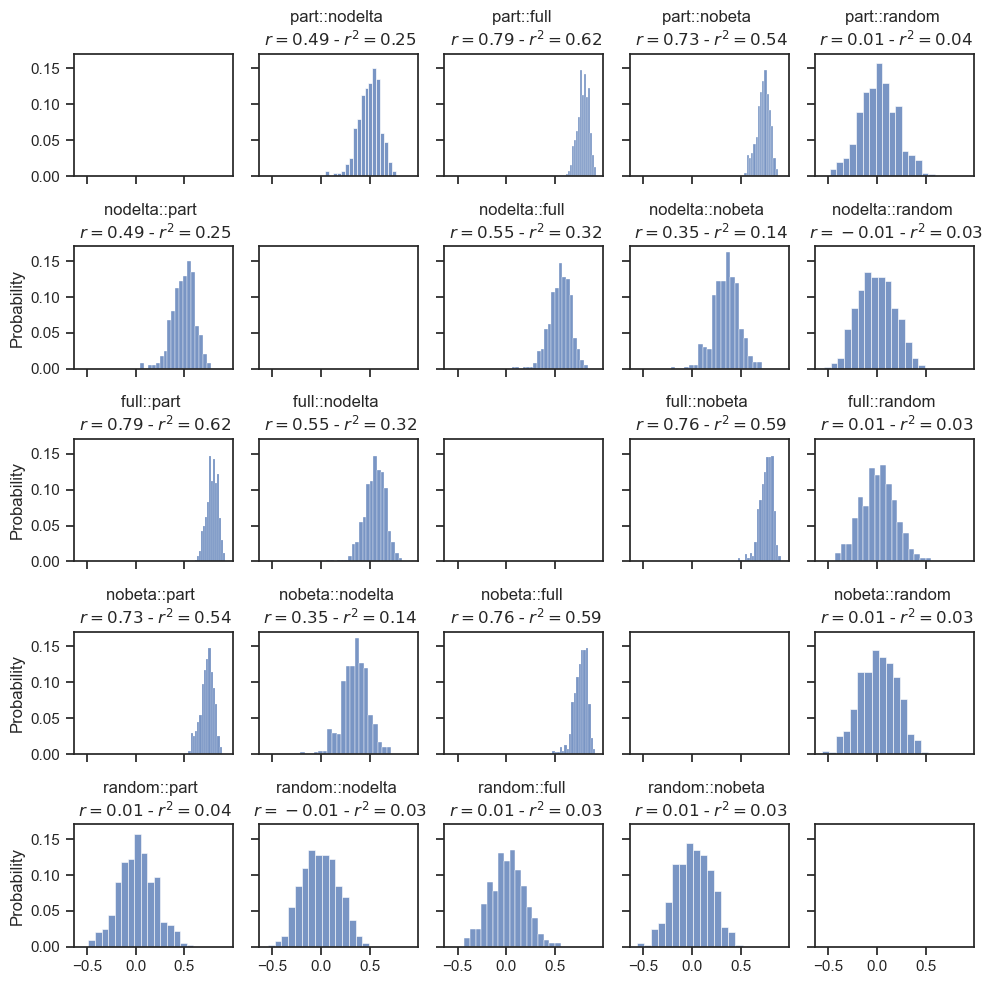

In [564]:
fig, axes = plt.subplots(len(cases), len(cases), figsize=(10, 10), sharex=True, sharey=True)

for i in range(len(cases)):
    for j in range(len(cases)):
        if i == j:
            continue
        ax = axes[i, j]

        sns.histplot(bootstrap_corr[:, i, j], ax=ax, stat='probability')

        rowname = cases[i]
        colname = cases[j]

        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(bootstrap_output[0, i, :], bootstrap_output[0, j, :])
        

        ax.set_title(f'{rowname}::{colname} \n $r={(bootstrap_corr[:, i, j].mean()).round(2)}$ - $r^2={(bootstrap_r2[:, i, j].mean()).round(2)}$')


plt.tight_layout()

In [663]:
variants

['nodelta', 'full', 'nobeta']

In [683]:
participants = df.participant_code.unique()
parts_1 = df[df.cluster == 0].participant_code.unique()
parts_1_N = len(parts_1)
parts_2 = df[df.cluster == 1].participant_code.unique()
parts_2_N = len(parts_2)

col_order = ['cluster', 'certainty_lvl', 'trust_lvl', 'path_idx']
col_order_M = ['cluster', 'certainty_lvl', 'trust_lvl', 'path_idx_sim']

cases = [
    'part',
    *variants,
    'random'
]
N_samples = 200
M_bootstrap = 99
bootstrap_output = np.zeros((N_samples, len(cases), 2, 36))
bootstrap_corr = np.zeros((N_samples, 2, len(cases), len(cases)))
bootstrap_r2 = np.zeros((N_samples, 2, len(cases), len(cases)))

observed = True

i = 0
failed = 0
while i < N_samples:

    sample_1 = np.random.choice(parts_1, parts_1_N, replace=True)
    sample_2 = np.random.choice(parts_2, parts_2_N, replace=True)
    sample = np.concatenate([sample_1, sample_2]).flatten()
    unique_ids_values = pd.Series(sample).value_counts()

    # Participant data
    part_data = []

    for code, num in zip(unique_ids_values.index, unique_ids_values.values):
        # Participant data
        part_arr = df[(df.block_type == 'test') & (df.participant_code == code) & (df.path_taken.notna())][col_order].to_numpy()
        part_data += [part_arr for _ in range(num)]
    part_data = np.concatenate(part_data)
    df_P = pd.DataFrame(part_data, columns=col_order)
    #df_P['path_idx'] = pd.Categorical(df_P.path_idx, categories=[1, 2, 3, 4], ordered=True)
    #df_P.sort_values(col_order[:-1], inplace=True)

    df_P_bs = df_P.groupby(col_order[:-1], observed=observed).path_idx.value_counts(normalize=True)
    df_P_bs = df_P_bs.reindex([1, 2, 3, 4], level=3).fillna(0)
    df_P_bs = df_P_bs.reindex([1, 2, 3], level=2).fillna(0)
    # Reindex to have all paths
    
    try:
        for c in range(2):
            bs_P_freqs = df_P_bs.xs(c, level=0).values
            #print(i, 'part', c, bs_P_freqs)
            bootstrap_output[i, 0, c, :] = bs_P_freqs     
    except:
        failed += 1
        continue

    # Random data
    df_R = pd.DataFrame(part_data, columns=col_order)
    df_R['path_idx'] = np.random.choice([1, 2, 3, 4], df_R.shape[0])
    #df_R['path_idx'] = pd.Categorical(df_P.path_idx, categories=[1, 2, 3, 4], ordered=True)
    #df_R.sort_values(col_order[:-1], inplace=True)

    df_R_bs = df_R.groupby(col_order[:-1], observed=observed).path_idx.value_counts(normalize=True)
    df_R_bs = df_R_bs.reindex([1, 2, 3, 4], level=3).fillna(0)
    df_R_bs = df_R_bs.reindex([1, 2, 3], level=2).fillna(0)

    try:
        for c in range(2):
            bs_R_freqs = df_R_bs.xs(c, level=0).values
            #print(i, 'random', c, bs_R_freqs)
            bootstrap_output[i, -1, c, :] = bs_R_freqs
    except:
        failed += 1
        continue

    variant_failed = False
    # Model data
    for j, variant in enumerate(variants):
        df_Ys = variants_df_Ys[variant]
        sim_idx = np.random.choice(df_Ys.sim_idx.unique())
        
        df_Ys_selected = df_Ys[(df_Ys.sim_idx == sim_idx)][col_order_M].to_numpy()
        df_M = pd.DataFrame(df_Ys_selected, columns=col_order)
        #df_M['path_idx'] = pd.Categorical(df_P.path_idx, categories=[1, 2, 3, 4], ordered=True)
        #df_M.sort_values(col_order[:-1], inplace=True)

        df_M_bs = df_M.groupby(col_order[:-1], observed=observed).path_idx.value_counts(normalize=True)
        # Reinex to have all paths
        df_M_bs = df_M_bs.reindex([1, 2, 3, 4], level=3).fillna(0)
        df_M_bs = df_M_bs.reindex([1, 2, 3], level=2).fillna(0)

        try:
            for c in range(2):
                bs_M_freqs = df_M_bs.xs(c, level=0).values
                bootstrap_output[i, j+1, c, :] = bs_M_freqs
            variant_failed = False
        except:
            failed += 1
            variant_failed = True
            break
    
    if variant_failed:
        #print(variant, 'failed')
        continue

    # Compute pairwise correlations
    for j in range(len(cases)):
        for k in range(len(cases)):
            #print(k, cases[k], bootstrap_output[i, k, 0, :])
            for c in range(2):
                bootstrap_corr[i, c, j, k] = stats.pearsonr(bootstrap_output[i, j, c, :], bootstrap_output[i, k, c, :])[0]
                bootstrap_r2[i, c, j, k] = bootstrap_corr[i, c, j, k] ** 2

    if i % 20 == 0:
        print(f'Sample {i+1} done')
    
    i += 1

print(f'Failed {failed} samples')

Sample 1 done
Sample 21 done
Sample 41 done
Sample 61 done
Sample 81 done
Sample 101 done
Sample 121 done
Sample 141 done
Sample 161 done
Sample 181 done
Failed 90 samples


In [680]:
bootstrap_output[0, 3, 1, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [656]:
bootstrap_corr[:, :, 0, 3]

array([nan, nan])

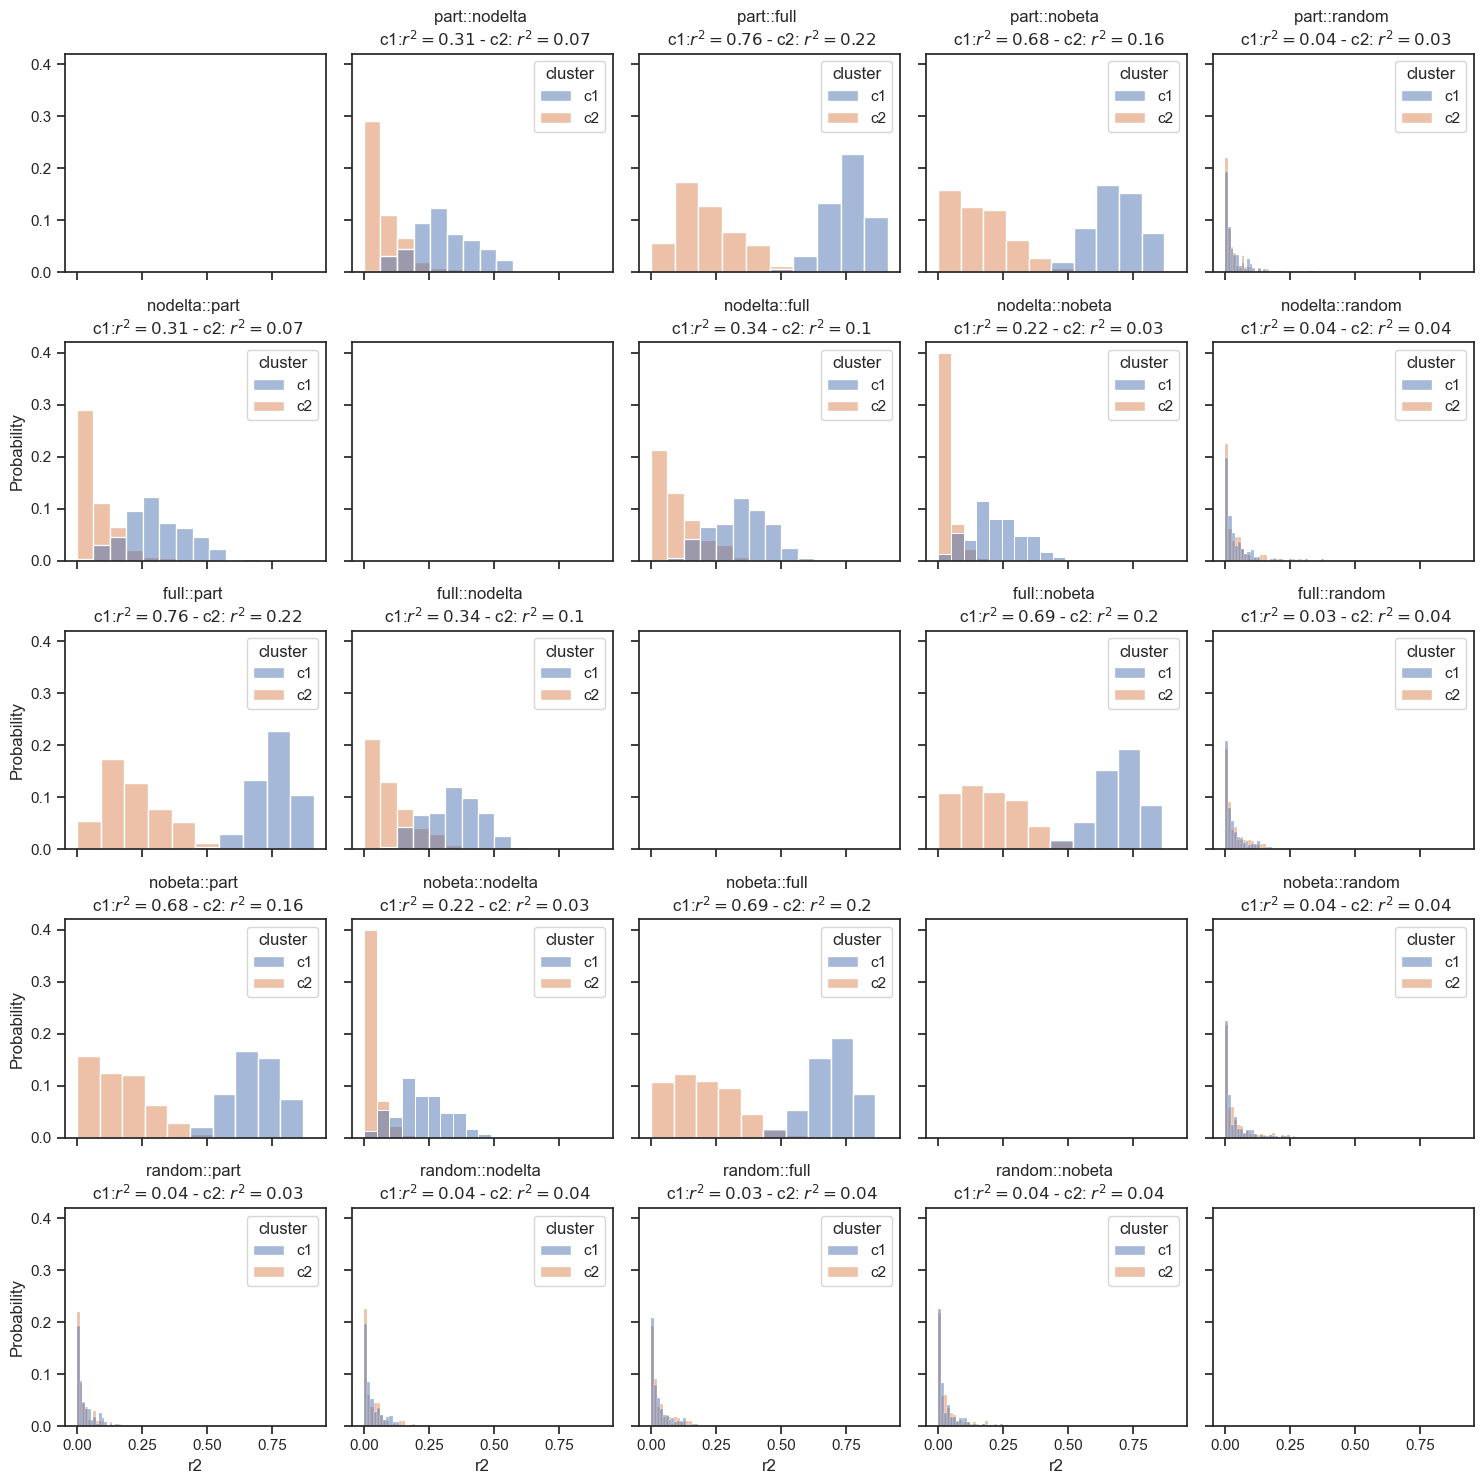

In [693]:
fig, axes = plt.subplots(len(cases), len(cases), figsize=(15, 15), sharex=True, sharey=True)

cluster = 1
for i in range(len(cases)):
    for j in range(len(cases)):
        if i == j:
            continue
        ax = axes[i, j]

        df_r = pd.DataFrame(bootstrap_corr[:, :, i, j], columns=['c1', 'c2'])
        df_r_l = df_r.melt(value_vars=['c1', 'c2'], var_name='cluster', value_name='r')

        df_r2 = pd.DataFrame(bootstrap_r2[:, :, i, j], columns=['c1', 'c2'])
        df_r2_l = df_r2.melt(value_vars=['c1', 'c2'], var_name='cluster', value_name='r2')
        
        sns.histplot(df_r2_l, x='r2', hue='cluster', ax=ax, stat='probability')

        rowname = cases[i]
        colname = cases[j]

        ax.set_title(f'{rowname}::{colname} \n c1:$r^2={(bootstrap_r2[:, 0, i, j].mean()).round(2)}$ - c2: $r^2={(bootstrap_r2[:, 1, i, j].mean()).round(2)}$')


plt.tight_layout()

In [688]:
df_bs_l

,cluster,r
0,c1,0.284794
1,c1,-0.445454
2,c1,-0.334362
3,c1,0.146829
4,c1,0.098304
...,...,...
395,c2,-0.218653
396,c2,0.096004
397,c2,-0.183536
398,c2,0.204292


In [572]:
df_P_bs

cluster  certainty_lvl  trust_lvl  path_idx
0        1              1          1           0.666667
                                   2           0.222222
                                   3           0.044444
                                   4           0.066667
                        2          1           0.400000
                                                 ...   
1        3              2          4           0.444444
                        3          1           0.240741
                                   2           0.259259
                                   3           0.240741
                                   4           0.259259
Name: proportion, Length: 72, dtype: float64

In [575]:
df_M_bs

cluster  certainty_lvl  trust_lvl  path_idx
0        1              1          1           0.612245
                                   2           0.183673
                                   3           0.163265
                                   4           0.040816
                        2          1           0.530612
                                                 ...   
1        3              2          4           0.240000
                        3          1           0.180000
                                   2           0.300000
                                   3           0.220000
                                   4           0.300000
Name: proportion, Length: 72, dtype: float64